In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

In [2]:
patch_size = 56
batch_size = 128
latent_dim = 128

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches  -- tensor of stacked patches    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches = []
    
    for file_patch in files_patches:
        patch = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patches.append(patch)
        
    patches = np.array(patches)
    patches = patches.astype(np.float64) / 255
    patches = np.expand_dims(patches, -1)
        
    print("patches shape:", patches.shape)
    
    return patches

In [5]:
x_train = loading_data(train_data_dir)
x_validation = loading_data(validation_data_dir)

patches shape: (64598, 56, 56, 1)
patches shape: (8075, 56, 56, 1)


In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
encoder_inputs = keras.Input(shape=(patch_size, patch_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 56, 56, 1)         289 

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
#             print(data.shape)
#             print(data[0])
#             print(type(data))
#             print(type(data[0]))
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [21]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [22]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))  # change lr from 0.001 (default) to 0.0001

In [23]:
model_version_old = "0.0.0.5"
vae.load_weights(base_dir + '/vae_' + model_version_old + '.h5')

Epoch 11520/11520 (last)
505/505  - 6s 11ms/step - loss: 413.7224 - reconstruction_loss: 412.1891 - kl_loss: 1.5333

In [29]:
model_version = "0.0.0.8_lr0.0001_45moreepochs"
os.system('mkdir ' + base_dir + '/weights_vae_' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights_vae_' + model_version + '/weights.{epoch:02d}-{loss:.2f}.h5', monitor='loss',
    verbose=0, save_best_only=False, save_weights_only=True, mode='auto', save_freq='epoch', period=128)


history_callback = vae.fit(x_train, epochs=43 * batch_size, batch_size=batch_size)


vae.save_weights(base_dir + '/vae_' + model_version + '.h5')

Epoch 1/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2823 - reconstruction_loss: 411.7175 - kl_loss: 1.5648
Epoch 2/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2972 - reconstruction_loss: 411.7322 - kl_loss: 1.5650
Epoch 3/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2040 - reconstruction_loss: 411.6381 - kl_loss: 1.5659
Epoch 4/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2599 - reconstruction_loss: 411.6954 - kl_loss: 1.5646
Epoch 5/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2830 - reconstruction_loss: 411.7189 - kl_loss: 1.5641
Epoch 6/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2676 - reconstruction_loss: 411.7032 - kl_loss: 1.5645
Epoch 7/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3113 - reconstruction_loss: 411.7457 - kl_loss: 1.5657
Epoch 8/5504
505/505 [==========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2520 - reconstruction_loss: 411.6871 - kl_loss: 1.5649
Epoch 60/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2779 - reconstruction_loss: 411.7133 - kl_loss: 1.5646
Epoch 61/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2669 - reconstruction_loss: 411.7024 - kl_loss: 1.5645
Epoch 62/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2680 - reconstruction_loss: 411.7033 - kl_loss: 1.5647
Epoch 63/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2793 - reconstruction_loss: 411.7148 - kl_loss: 1.5644
Epoch 64/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3009 - reconstruction_loss: 411.7366 - kl_loss: 1.5643
Epoch 65/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2799 - reconstruction_loss: 411.7156 - kl_loss: 1.5643
Epoch 66/5504
505/505 [==============================] 

505/505 [==============================] - 6s 11ms/step - loss: 413.2803 - reconstruction_loss: 411.7155 - kl_loss: 1.5648
Epoch 119/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2757 - reconstruction_loss: 411.7107 - kl_loss: 1.5650
Epoch 120/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2779 - reconstruction_loss: 411.7134 - kl_loss: 1.5645
Epoch 121/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2409 - reconstruction_loss: 411.6758 - kl_loss: 1.5652
Epoch 122/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3039 - reconstruction_loss: 411.7378 - kl_loss: 1.5662
Epoch 123/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3374 - reconstruction_loss: 411.7717 - kl_loss: 1.5657
Epoch 124/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2721 - reconstruction_loss: 411.7066 - kl_loss: 1.5655
Epoch 125/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2625 - reconstruction_loss: 411.6969 - kl_loss: 1.5656
Epoch 178/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2657 - reconstruction_loss: 411.7012 - kl_loss: 1.5645
Epoch 179/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2221 - reconstruction_loss: 411.6571 - kl_loss: 1.5650
Epoch 180/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2595 - reconstruction_loss: 411.6944 - kl_loss: 1.5651
Epoch 181/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2105 - reconstruction_loss: 411.6449 - kl_loss: 1.5656
Epoch 182/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2620 - reconstruction_loss: 411.6966 - kl_loss: 1.5654
Epoch 183/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2989 - reconstruction_loss: 411.7338 - kl_loss: 1.5651
Epoch 184/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2303 - reconstruction_loss: 411.6655 - kl_loss: 1.5648
Epoch 237/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2571 - reconstruction_loss: 411.6921 - kl_loss: 1.5650
Epoch 238/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2660 - reconstruction_loss: 411.7002 - kl_loss: 1.5658
Epoch 239/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2524 - reconstruction_loss: 411.6870 - kl_loss: 1.5654
Epoch 240/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2116 - reconstruction_loss: 411.6462 - kl_loss: 1.5654
Epoch 241/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2541 - reconstruction_loss: 411.6888 - kl_loss: 1.5653
Epoch 242/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2827 - reconstruction_loss: 411.7176 - kl_loss: 1.5650
Epoch 243/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2438 - reconstruction_loss: 411.6796 - kl_loss: 1.5642
Epoch 296/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2873 - reconstruction_loss: 411.7223 - kl_loss: 1.5650
Epoch 297/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2636 - reconstruction_loss: 411.6980 - kl_loss: 1.5656
Epoch 298/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2366 - reconstruction_loss: 411.6714 - kl_loss: 1.5652
Epoch 299/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2551 - reconstruction_loss: 411.6901 - kl_loss: 1.5651
Epoch 300/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2827 - reconstruction_loss: 411.7178 - kl_loss: 1.5649
Epoch 301/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2859 - reconstruction_loss: 411.7200 - kl_loss: 1.5659
Epoch 302/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2607 - reconstruction_loss: 411.6951 - kl_loss: 1.5655
Epoch 355/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2949 - reconstruction_loss: 411.7296 - kl_loss: 1.5652
Epoch 356/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3109 - reconstruction_loss: 411.7456 - kl_loss: 1.5653
Epoch 357/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2943 - reconstruction_loss: 411.7295 - kl_loss: 1.5648
Epoch 358/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2184 - reconstruction_loss: 411.6528 - kl_loss: 1.5656
Epoch 359/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2628 - reconstruction_loss: 411.6971 - kl_loss: 1.5657
Epoch 360/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3013 - reconstruction_loss: 411.7361 - kl_loss: 1.5652
Epoch 361/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2493 - reconstruction_loss: 411.6843 - kl_loss: 1.5650
Epoch 414/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2866 - reconstruction_loss: 411.7202 - kl_loss: 1.5664
Epoch 415/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3100 - reconstruction_loss: 411.7443 - kl_loss: 1.5657
Epoch 416/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2680 - reconstruction_loss: 411.7024 - kl_loss: 1.5655
Epoch 417/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2228 - reconstruction_loss: 411.6579 - kl_loss: 1.5649
Epoch 418/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3013 - reconstruction_loss: 411.7358 - kl_loss: 1.5655
Epoch 419/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2507 - reconstruction_loss: 411.6857 - kl_loss: 1.5651
Epoch 420/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3029 - reconstruction_loss: 411.7379 - kl_loss: 1.5651
Epoch 473/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2462 - reconstruction_loss: 411.6805 - kl_loss: 1.5657
Epoch 474/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2390 - reconstruction_loss: 411.6738 - kl_loss: 1.5652
Epoch 475/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2227 - reconstruction_loss: 411.6584 - kl_loss: 1.5644
Epoch 476/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2352 - reconstruction_loss: 411.6697 - kl_loss: 1.5656
Epoch 477/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2708 - reconstruction_loss: 411.7055 - kl_loss: 1.5652
Epoch 478/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2539 - reconstruction_loss: 411.6891 - kl_loss: 1.5649
Epoch 479/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2766 - reconstruction_loss: 411.7109 - kl_loss: 1.5657
Epoch 532/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2742 - reconstruction_loss: 411.7095 - kl_loss: 1.5647
Epoch 533/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2894 - reconstruction_loss: 411.7244 - kl_loss: 1.5650
Epoch 534/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2925 - reconstruction_loss: 411.7268 - kl_loss: 1.5657
Epoch 535/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3008 - reconstruction_loss: 411.7360 - kl_loss: 1.5647
Epoch 536/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2934 - reconstruction_loss: 411.7273 - kl_loss: 1.5661
Epoch 537/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2847 - reconstruction_loss: 411.7195 - kl_loss: 1.5652
Epoch 538/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2626 - reconstruction_loss: 411.6974 - kl_loss: 1.5652
Epoch 591/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2515 - reconstruction_loss: 411.6857 - kl_loss: 1.5659
Epoch 592/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2935 - reconstruction_loss: 411.7284 - kl_loss: 1.5651
Epoch 593/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2759 - reconstruction_loss: 411.7107 - kl_loss: 1.5652
Epoch 594/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2646 - reconstruction_loss: 411.7000 - kl_loss: 1.5647
Epoch 595/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3238 - reconstruction_loss: 411.7583 - kl_loss: 1.5655
Epoch 596/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2745 - reconstruction_loss: 411.7095 - kl_loss: 1.5650
Epoch 597/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3184 - reconstruction_loss: 411.7534 - kl_loss: 1.5650
Epoch 650/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.1943 - reconstruction_loss: 411.6288 - kl_loss: 1.5655
Epoch 651/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2605 - reconstruction_loss: 411.6953 - kl_loss: 1.5652
Epoch 652/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2345 - reconstruction_loss: 411.6687 - kl_loss: 1.5658
Epoch 653/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2595 - reconstruction_loss: 411.6937 - kl_loss: 1.5658
Epoch 654/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2480 - reconstruction_loss: 411.6818 - kl_loss: 1.5661
Epoch 655/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2952 - reconstruction_loss: 411.7295 - kl_loss: 1.5657
Epoch 656/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2340 - reconstruction_loss: 411.6697 - kl_loss: 1.5643
Epoch 709/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2876 - reconstruction_loss: 411.7222 - kl_loss: 1.5654
Epoch 710/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2519 - reconstruction_loss: 411.6870 - kl_loss: 1.5649
Epoch 711/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2860 - reconstruction_loss: 411.7212 - kl_loss: 1.5648
Epoch 712/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3054 - reconstruction_loss: 411.7400 - kl_loss: 1.5654
Epoch 713/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2679 - reconstruction_loss: 411.7028 - kl_loss: 1.5651
Epoch 714/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2348 - reconstruction_loss: 411.6699 - kl_loss: 1.5649
Epoch 715/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2833 - reconstruction_loss: 411.7178 - kl_loss: 1.5655
Epoch 768/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2677 - reconstruction_loss: 411.7023 - kl_loss: 1.5655
Epoch 769/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2455 - reconstruction_loss: 411.6807 - kl_loss: 1.5649
Epoch 770/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3171 - reconstruction_loss: 411.7528 - kl_loss: 1.5643
Epoch 771/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2650 - reconstruction_loss: 411.6992 - kl_loss: 1.5658
Epoch 772/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2898 - reconstruction_loss: 411.7250 - kl_loss: 1.5648
Epoch 773/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2862 - reconstruction_loss: 411.7205 - kl_loss: 1.5657
Epoch 774/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2319 - reconstruction_loss: 411.6660 - kl_loss: 1.5659
Epoch 827/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2521 - reconstruction_loss: 411.6872 - kl_loss: 1.5650
Epoch 828/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2418 - reconstruction_loss: 411.6758 - kl_loss: 1.5659
Epoch 829/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2229 - reconstruction_loss: 411.6579 - kl_loss: 1.5651
Epoch 830/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2319 - reconstruction_loss: 411.6667 - kl_loss: 1.5652
Epoch 831/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2552 - reconstruction_loss: 411.6889 - kl_loss: 1.5662
Epoch 832/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2342 - reconstruction_loss: 411.6691 - kl_loss: 1.5651
Epoch 833/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3192 - reconstruction_loss: 411.7540 - kl_loss: 1.5652
Epoch 886/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2666 - reconstruction_loss: 411.7016 - kl_loss: 1.5650
Epoch 887/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2583 - reconstruction_loss: 411.6925 - kl_loss: 1.5657
Epoch 888/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2113 - reconstruction_loss: 411.6460 - kl_loss: 1.5653
Epoch 889/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2214 - reconstruction_loss: 411.6558 - kl_loss: 1.5656
Epoch 890/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2380 - reconstruction_loss: 411.6718 - kl_loss: 1.5661
Epoch 891/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2859 - reconstruction_loss: 411.7199 - kl_loss: 1.5661
Epoch 892/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2821 - reconstruction_loss: 411.7171 - kl_loss: 1.5650
Epoch 945/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2357 - reconstruction_loss: 411.6700 - kl_loss: 1.5657
Epoch 946/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2420 - reconstruction_loss: 411.6763 - kl_loss: 1.5657
Epoch 947/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2737 - reconstruction_loss: 411.7074 - kl_loss: 1.5663
Epoch 948/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3033 - reconstruction_loss: 411.7383 - kl_loss: 1.5649
Epoch 949/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2508 - reconstruction_loss: 411.6850 - kl_loss: 1.5658
Epoch 950/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.1754 - reconstruction_loss: 411.6098 - kl_loss: 1.5656
Epoch 951/5504
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2796 - reconstruction_loss: 411.7148 - kl_loss: 1.5648
Epoch 1004/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2856 - reconstruction_loss: 411.7201 - kl_loss: 1.5655
Epoch 1005/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2828 - reconstruction_loss: 411.7160 - kl_loss: 1.5667
Epoch 1006/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2284 - reconstruction_loss: 411.6620 - kl_loss: 1.5664
Epoch 1007/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2848 - reconstruction_loss: 411.7196 - kl_loss: 1.5652
Epoch 1008/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2755 - reconstruction_loss: 411.7101 - kl_loss: 1.5654
Epoch 1009/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2769 - reconstruction_loss: 411.7120 - kl_loss: 1.5649
Epoch 1010/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2498 - reconstruction_loss: 411.6841 - kl_loss: 1.5657
Epoch 1063/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2897 - reconstruction_loss: 411.7244 - kl_loss: 1.5653
Epoch 1064/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2844 - reconstruction_loss: 411.7183 - kl_loss: 1.5661
Epoch 1065/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2623 - reconstruction_loss: 411.6965 - kl_loss: 1.5659
Epoch 1066/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2284 - reconstruction_loss: 411.6628 - kl_loss: 1.5656
Epoch 1067/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2533 - reconstruction_loss: 411.6883 - kl_loss: 1.5651
Epoch 1068/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2740 - reconstruction_loss: 411.7082 - kl_loss: 1.5658
Epoch 1069/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2622 - reconstruction_loss: 411.6961 - kl_loss: 1.5661
Epoch 1122/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2608 - reconstruction_loss: 411.6957 - kl_loss: 1.5651
Epoch 1123/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2643 - reconstruction_loss: 411.6987 - kl_loss: 1.5656
Epoch 1124/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2813 - reconstruction_loss: 411.7167 - kl_loss: 1.5646
Epoch 1125/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2780 - reconstruction_loss: 411.7116 - kl_loss: 1.5664
Epoch 1126/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2661 - reconstruction_loss: 411.7011 - kl_loss: 1.5649
Epoch 1127/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2647 - reconstruction_loss: 411.6995 - kl_loss: 1.5652
Epoch 1128/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2714 - reconstruction_loss: 411.7064 - kl_loss: 1.5650
Epoch 1181/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2585 - reconstruction_loss: 411.6924 - kl_loss: 1.5661
Epoch 1182/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2472 - reconstruction_loss: 411.6823 - kl_loss: 1.5649
Epoch 1183/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2507 - reconstruction_loss: 411.6850 - kl_loss: 1.5658
Epoch 1184/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2424 - reconstruction_loss: 411.6768 - kl_loss: 1.5657
Epoch 1185/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2694 - reconstruction_loss: 411.7042 - kl_loss: 1.5652
Epoch 1186/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2767 - reconstruction_loss: 411.7109 - kl_loss: 1.5658
Epoch 1187/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2953 - reconstruction_loss: 411.7295 - kl_loss: 1.5658
Epoch 1240/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2509 - reconstruction_loss: 411.6858 - kl_loss: 1.5651
Epoch 1241/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2914 - reconstruction_loss: 411.7255 - kl_loss: 1.5659
Epoch 1242/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2305 - reconstruction_loss: 411.6648 - kl_loss: 1.5657
Epoch 1243/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2859 - reconstruction_loss: 411.7210 - kl_loss: 1.5649
Epoch 1244/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2263 - reconstruction_loss: 411.6610 - kl_loss: 1.5653
Epoch 1245/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2734 - reconstruction_loss: 411.7076 - kl_loss: 1.5658
Epoch 1246/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2920 - reconstruction_loss: 411.7274 - kl_loss: 1.5647
Epoch 1299/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2645 - reconstruction_loss: 411.6990 - kl_loss: 1.5655
Epoch 1300/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2314 - reconstruction_loss: 411.6657 - kl_loss: 1.5657
Epoch 1301/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2974 - reconstruction_loss: 411.7316 - kl_loss: 1.5658
Epoch 1302/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2889 - reconstruction_loss: 411.7232 - kl_loss: 1.5657
Epoch 1303/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2591 - reconstruction_loss: 411.6937 - kl_loss: 1.5655
Epoch 1304/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2672 - reconstruction_loss: 411.7021 - kl_loss: 1.5651
Epoch 1305/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2549 - reconstruction_loss: 411.6886 - kl_loss: 1.5663
Epoch 1358/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2595 - reconstruction_loss: 411.6942 - kl_loss: 1.5653
Epoch 1359/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2349 - reconstruction_loss: 411.6701 - kl_loss: 1.5648
Epoch 1360/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2702 - reconstruction_loss: 411.7047 - kl_loss: 1.5655
Epoch 1361/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2898 - reconstruction_loss: 411.7243 - kl_loss: 1.5655
Epoch 1362/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2665 - reconstruction_loss: 411.7008 - kl_loss: 1.5657
Epoch 1363/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2437 - reconstruction_loss: 411.6776 - kl_loss: 1.5662
Epoch 1364/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2532 - reconstruction_loss: 411.6874 - kl_loss: 1.5658
Epoch 1417/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2691 - reconstruction_loss: 411.7034 - kl_loss: 1.5656
Epoch 1418/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3145 - reconstruction_loss: 411.7491 - kl_loss: 1.5653
Epoch 1419/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2286 - reconstruction_loss: 411.6635 - kl_loss: 1.5651
Epoch 1420/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2754 - reconstruction_loss: 411.7097 - kl_loss: 1.5656
Epoch 1421/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2639 - reconstruction_loss: 411.6989 - kl_loss: 1.5650
Epoch 1422/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2548 - reconstruction_loss: 411.6889 - kl_loss: 1.5659
Epoch 1423/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2594 - reconstruction_loss: 411.6939 - kl_loss: 1.5655
Epoch 1476/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3026 - reconstruction_loss: 411.7369 - kl_loss: 1.5656
Epoch 1477/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2175 - reconstruction_loss: 411.6522 - kl_loss: 1.5653
Epoch 1478/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3229 - reconstruction_loss: 411.7569 - kl_loss: 1.5660
Epoch 1479/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2078 - reconstruction_loss: 411.6421 - kl_loss: 1.5656
Epoch 1480/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2183 - reconstruction_loss: 411.6524 - kl_loss: 1.5659
Epoch 1481/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3276 - reconstruction_loss: 411.7627 - kl_loss: 1.5649
Epoch 1482/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2474 - reconstruction_loss: 411.6815 - kl_loss: 1.5659
Epoch 1535/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2736 - reconstruction_loss: 411.7082 - kl_loss: 1.5654
Epoch 1536/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2826 - reconstruction_loss: 411.7169 - kl_loss: 1.5657
Epoch 1537/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2627 - reconstruction_loss: 411.6970 - kl_loss: 1.5657
Epoch 1538/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2542 - reconstruction_loss: 411.6889 - kl_loss: 1.5654
Epoch 1539/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2738 - reconstruction_loss: 411.7077 - kl_loss: 1.5661
Epoch 1540/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2677 - reconstruction_loss: 411.7022 - kl_loss: 1.5655
Epoch 1541/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2432 - reconstruction_loss: 411.6773 - kl_loss: 1.5659
Epoch 1594/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2250 - reconstruction_loss: 411.6593 - kl_loss: 1.5657
Epoch 1595/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2574 - reconstruction_loss: 411.6919 - kl_loss: 1.5654
Epoch 1596/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2471 - reconstruction_loss: 411.6819 - kl_loss: 1.5652
Epoch 1597/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2872 - reconstruction_loss: 411.7219 - kl_loss: 1.5653
Epoch 1598/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2717 - reconstruction_loss: 411.7060 - kl_loss: 1.5657
Epoch 1599/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2814 - reconstruction_loss: 411.7156 - kl_loss: 1.5659
Epoch 1600/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2985 - reconstruction_loss: 411.7326 - kl_loss: 1.5659
Epoch 1653/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2711 - reconstruction_loss: 411.7054 - kl_loss: 1.5658
Epoch 1654/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2606 - reconstruction_loss: 411.6962 - kl_loss: 1.5644
Epoch 1655/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2437 - reconstruction_loss: 411.6779 - kl_loss: 1.5658
Epoch 1656/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2832 - reconstruction_loss: 411.7171 - kl_loss: 1.5661
Epoch 1657/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2666 - reconstruction_loss: 411.7014 - kl_loss: 1.5652
Epoch 1658/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2798 - reconstruction_loss: 411.7140 - kl_loss: 1.5658
Epoch 1659/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2714 - reconstruction_loss: 411.7060 - kl_loss: 1.5653
Epoch 1712/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2355 - reconstruction_loss: 411.6702 - kl_loss: 1.5652
Epoch 1713/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2433 - reconstruction_loss: 411.6774 - kl_loss: 1.5659
Epoch 1714/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2379 - reconstruction_loss: 411.6724 - kl_loss: 1.5655
Epoch 1715/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2851 - reconstruction_loss: 411.7193 - kl_loss: 1.5658
Epoch 1716/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2423 - reconstruction_loss: 411.6764 - kl_loss: 1.5658
Epoch 1717/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2254 - reconstruction_loss: 411.6602 - kl_loss: 1.5652
Epoch 1718/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2692 - reconstruction_loss: 411.7037 - kl_loss: 1.5655
Epoch 1771/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2720 - reconstruction_loss: 411.7062 - kl_loss: 1.5658
Epoch 1772/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2577 - reconstruction_loss: 411.6914 - kl_loss: 1.5663
Epoch 1773/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2552 - reconstruction_loss: 411.6893 - kl_loss: 1.5659
Epoch 1774/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2283 - reconstruction_loss: 411.6629 - kl_loss: 1.5654
Epoch 1775/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2598 - reconstruction_loss: 411.6943 - kl_loss: 1.5654
Epoch 1776/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2385 - reconstruction_loss: 411.6727 - kl_loss: 1.5658
Epoch 1777/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2886 - reconstruction_loss: 411.7234 - kl_loss: 1.5652
Epoch 1830/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2594 - reconstruction_loss: 411.6948 - kl_loss: 1.5647
Epoch 1831/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3359 - reconstruction_loss: 411.7700 - kl_loss: 1.5659
Epoch 1832/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2546 - reconstruction_loss: 411.6887 - kl_loss: 1.5659
Epoch 1833/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2452 - reconstruction_loss: 411.6795 - kl_loss: 1.5657
Epoch 1834/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2480 - reconstruction_loss: 411.6823 - kl_loss: 1.5657
Epoch 1835/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2055 - reconstruction_loss: 411.6394 - kl_loss: 1.5660
Epoch 1836/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2531 - reconstruction_loss: 411.6872 - kl_loss: 1.5659
Epoch 1889/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2293 - reconstruction_loss: 411.6646 - kl_loss: 1.5647
Epoch 1890/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2912 - reconstruction_loss: 411.7252 - kl_loss: 1.5660
Epoch 1891/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2627 - reconstruction_loss: 411.6969 - kl_loss: 1.5657
Epoch 1892/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2368 - reconstruction_loss: 411.6711 - kl_loss: 1.5658
Epoch 1893/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2853 - reconstruction_loss: 411.7193 - kl_loss: 1.5660
Epoch 1894/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2432 - reconstruction_loss: 411.6773 - kl_loss: 1.5659
Epoch 1895/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2245 - reconstruction_loss: 411.6591 - kl_loss: 1.5654
Epoch 1948/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2278 - reconstruction_loss: 411.6611 - kl_loss: 1.5667
Epoch 1949/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2474 - reconstruction_loss: 411.6820 - kl_loss: 1.5654
Epoch 1950/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2555 - reconstruction_loss: 411.6895 - kl_loss: 1.5659
Epoch 1951/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2749 - reconstruction_loss: 411.7090 - kl_loss: 1.5659
Epoch 1952/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2304 - reconstruction_loss: 411.6643 - kl_loss: 1.5661
Epoch 1953/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3192 - reconstruction_loss: 411.7530 - kl_loss: 1.5662
Epoch 1954/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2468 - reconstruction_loss: 411.6807 - kl_loss: 1.5661
Epoch 2007/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2720 - reconstruction_loss: 411.7057 - kl_loss: 1.5664
Epoch 2008/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2825 - reconstruction_loss: 411.7171 - kl_loss: 1.5654
Epoch 2009/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2126 - reconstruction_loss: 411.6472 - kl_loss: 1.5654
Epoch 2010/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2912 - reconstruction_loss: 411.7262 - kl_loss: 1.5650
Epoch 2011/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2594 - reconstruction_loss: 411.6939 - kl_loss: 1.5655
Epoch 2012/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3035 - reconstruction_loss: 411.7377 - kl_loss: 1.5658
Epoch 2013/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2493 - reconstruction_loss: 411.6833 - kl_loss: 1.5659
Epoch 2066/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2742 - reconstruction_loss: 411.7087 - kl_loss: 1.5656
Epoch 2067/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3077 - reconstruction_loss: 411.7413 - kl_loss: 1.5664
Epoch 2068/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3041 - reconstruction_loss: 411.7384 - kl_loss: 1.5658
Epoch 2069/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2492 - reconstruction_loss: 411.6831 - kl_loss: 1.5660
Epoch 2070/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2455 - reconstruction_loss: 411.6797 - kl_loss: 1.5658
Epoch 2071/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2782 - reconstruction_loss: 411.7128 - kl_loss: 1.5654
Epoch 2072/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2594 - reconstruction_loss: 411.6931 - kl_loss: 1.5663
Epoch 2125/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2864 - reconstruction_loss: 411.7203 - kl_loss: 1.5661
Epoch 2126/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2944 - reconstruction_loss: 411.7282 - kl_loss: 1.5662
Epoch 2127/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2331 - reconstruction_loss: 411.6671 - kl_loss: 1.5660
Epoch 2128/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2974 - reconstruction_loss: 411.7316 - kl_loss: 1.5657
Epoch 2129/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2275 - reconstruction_loss: 411.6617 - kl_loss: 1.5658
Epoch 2130/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2864 - reconstruction_loss: 411.7210 - kl_loss: 1.5654
Epoch 2131/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2658 - reconstruction_loss: 411.7003 - kl_loss: 1.5655
Epoch 2184/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2008 - reconstruction_loss: 411.6353 - kl_loss: 1.5656
Epoch 2185/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3383 - reconstruction_loss: 411.7722 - kl_loss: 1.5661
Epoch 2186/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2681 - reconstruction_loss: 411.7020 - kl_loss: 1.5661
Epoch 2187/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2177 - reconstruction_loss: 411.6514 - kl_loss: 1.5663
Epoch 2188/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2462 - reconstruction_loss: 411.6803 - kl_loss: 1.5659
Epoch 2189/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2327 - reconstruction_loss: 411.6664 - kl_loss: 1.5663
Epoch 2190/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2723 - reconstruction_loss: 411.7069 - kl_loss: 1.5654
Epoch 2243/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2517 - reconstruction_loss: 411.6860 - kl_loss: 1.5657
Epoch 2244/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2938 - reconstruction_loss: 411.7283 - kl_loss: 1.5656
Epoch 2245/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2749 - reconstruction_loss: 411.7086 - kl_loss: 1.5662
Epoch 2246/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2284 - reconstruction_loss: 411.6622 - kl_loss: 1.5662
Epoch 2247/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3042 - reconstruction_loss: 411.7383 - kl_loss: 1.5659
Epoch 2248/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2381 - reconstruction_loss: 411.6722 - kl_loss: 1.5659
Epoch 2249/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3258 - reconstruction_loss: 411.7601 - kl_loss: 1.5657
Epoch 2302/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2746 - reconstruction_loss: 411.7084 - kl_loss: 1.5662
Epoch 2303/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2525 - reconstruction_loss: 411.6865 - kl_loss: 1.5659
Epoch 2304/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2957 - reconstruction_loss: 411.7292 - kl_loss: 1.5664
Epoch 2305/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2654 - reconstruction_loss: 411.6992 - kl_loss: 1.5662
Epoch 2306/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2803 - reconstruction_loss: 411.7144 - kl_loss: 1.5659
Epoch 2307/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2877 - reconstruction_loss: 411.7221 - kl_loss: 1.5656
Epoch 2308/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2088 - reconstruction_loss: 411.6427 - kl_loss: 1.5661
Epoch 2361/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2185 - reconstruction_loss: 411.6528 - kl_loss: 1.5657
Epoch 2362/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3174 - reconstruction_loss: 411.7521 - kl_loss: 1.5653
Epoch 2363/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3055 - reconstruction_loss: 411.7395 - kl_loss: 1.5660
Epoch 2364/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2229 - reconstruction_loss: 411.6570 - kl_loss: 1.5659
Epoch 2365/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2508 - reconstruction_loss: 411.6843 - kl_loss: 1.5666
Epoch 2366/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2303 - reconstruction_loss: 411.6644 - kl_loss: 1.5659
Epoch 2367/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2832 - reconstruction_loss: 411.7169 - kl_loss: 1.5664
Epoch 2420/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2734 - reconstruction_loss: 411.7073 - kl_loss: 1.5661
Epoch 2421/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2754 - reconstruction_loss: 411.7094 - kl_loss: 1.5660
Epoch 2422/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2516 - reconstruction_loss: 411.6856 - kl_loss: 1.5660
Epoch 2423/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2643 - reconstruction_loss: 411.6989 - kl_loss: 1.5655
Epoch 2424/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2376 - reconstruction_loss: 411.6712 - kl_loss: 1.5664
Epoch 2425/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2173 - reconstruction_loss: 411.6516 - kl_loss: 1.5658
Epoch 2426/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2866 - reconstruction_loss: 411.7203 - kl_loss: 1.5663
Epoch 2479/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2352 - reconstruction_loss: 411.6689 - kl_loss: 1.5663
Epoch 2480/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2807 - reconstruction_loss: 411.7143 - kl_loss: 1.5664
Epoch 2481/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2716 - reconstruction_loss: 411.7052 - kl_loss: 1.5664
Epoch 2482/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3203 - reconstruction_loss: 411.7550 - kl_loss: 1.5653
Epoch 2483/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2587 - reconstruction_loss: 411.6922 - kl_loss: 1.5664
Epoch 2484/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2693 - reconstruction_loss: 411.7031 - kl_loss: 1.5662
Epoch 2485/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2633 - reconstruction_loss: 411.6969 - kl_loss: 1.5664
Epoch 2538/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2970 - reconstruction_loss: 411.7310 - kl_loss: 1.5660
Epoch 2539/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2864 - reconstruction_loss: 411.7210 - kl_loss: 1.5654
Epoch 2540/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2682 - reconstruction_loss: 411.7023 - kl_loss: 1.5658
Epoch 2541/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3054 - reconstruction_loss: 411.7395 - kl_loss: 1.5659
Epoch 2542/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2445 - reconstruction_loss: 411.6790 - kl_loss: 1.5655
Epoch 2543/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2454 - reconstruction_loss: 411.6795 - kl_loss: 1.5659
Epoch 2544/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2611 - reconstruction_loss: 411.6945 - kl_loss: 1.5666
Epoch 2597/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2522 - reconstruction_loss: 411.6867 - kl_loss: 1.5655
Epoch 2598/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2680 - reconstruction_loss: 411.7019 - kl_loss: 1.5660
Epoch 2599/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2233 - reconstruction_loss: 411.6572 - kl_loss: 1.5662
Epoch 2600/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2256 - reconstruction_loss: 411.6590 - kl_loss: 1.5666
Epoch 2601/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2568 - reconstruction_loss: 411.6904 - kl_loss: 1.5664
Epoch 2602/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2449 - reconstruction_loss: 411.6801 - kl_loss: 1.5648
Epoch 2603/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2521 - reconstruction_loss: 411.6859 - kl_loss: 1.5662
Epoch 2656/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2979 - reconstruction_loss: 411.7320 - kl_loss: 1.5659
Epoch 2657/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2679 - reconstruction_loss: 411.7024 - kl_loss: 1.5655
Epoch 2658/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2738 - reconstruction_loss: 411.7079 - kl_loss: 1.5659
Epoch 2659/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2606 - reconstruction_loss: 411.6943 - kl_loss: 1.5664
Epoch 2660/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2750 - reconstruction_loss: 411.7093 - kl_loss: 1.5657
Epoch 2661/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2198 - reconstruction_loss: 411.6540 - kl_loss: 1.5659
Epoch 2662/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2342 - reconstruction_loss: 411.6676 - kl_loss: 1.5666
Epoch 2715/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2748 - reconstruction_loss: 411.7088 - kl_loss: 1.5660
Epoch 2716/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2437 - reconstruction_loss: 411.6775 - kl_loss: 1.5662
Epoch 2717/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2583 - reconstruction_loss: 411.6917 - kl_loss: 1.5666
Epoch 2718/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2256 - reconstruction_loss: 411.6584 - kl_loss: 1.5671
Epoch 2719/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2528 - reconstruction_loss: 411.6861 - kl_loss: 1.5668
Epoch 2720/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3042 - reconstruction_loss: 411.7383 - kl_loss: 1.5659
Epoch 2721/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2190 - reconstruction_loss: 411.6536 - kl_loss: 1.5654
Epoch 2774/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2704 - reconstruction_loss: 411.7051 - kl_loss: 1.5653
Epoch 2775/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2619 - reconstruction_loss: 411.6954 - kl_loss: 1.5666
Epoch 2776/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2936 - reconstruction_loss: 411.7271 - kl_loss: 1.5665
Epoch 2777/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2959 - reconstruction_loss: 411.7298 - kl_loss: 1.5661
Epoch 2778/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2439 - reconstruction_loss: 411.6778 - kl_loss: 1.5660
Epoch 2779/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2470 - reconstruction_loss: 411.6813 - kl_loss: 1.5657
Epoch 2780/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2794 - reconstruction_loss: 411.7132 - kl_loss: 1.5662
Epoch 2833/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2462 - reconstruction_loss: 411.6803 - kl_loss: 1.5659
Epoch 2834/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2911 - reconstruction_loss: 411.7250 - kl_loss: 1.5662
Epoch 2835/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2232 - reconstruction_loss: 411.6572 - kl_loss: 1.5660
Epoch 2836/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2742 - reconstruction_loss: 411.7084 - kl_loss: 1.5658
Epoch 2837/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2626 - reconstruction_loss: 411.6964 - kl_loss: 1.5661
Epoch 2838/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3031 - reconstruction_loss: 411.7375 - kl_loss: 1.5656
Epoch 2839/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2895 - reconstruction_loss: 411.7230 - kl_loss: 1.5665
Epoch 2892/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2479 - reconstruction_loss: 411.6814 - kl_loss: 1.5665
Epoch 2893/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2855 - reconstruction_loss: 411.7196 - kl_loss: 1.5659
Epoch 2894/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2950 - reconstruction_loss: 411.7296 - kl_loss: 1.5654
Epoch 2895/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2290 - reconstruction_loss: 411.6624 - kl_loss: 1.5666
Epoch 2896/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2129 - reconstruction_loss: 411.6470 - kl_loss: 1.5659
Epoch 2897/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2282 - reconstruction_loss: 411.6619 - kl_loss: 1.5663
Epoch 2898/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2507 - reconstruction_loss: 411.6853 - kl_loss: 1.5654
Epoch 2951/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3330 - reconstruction_loss: 411.7670 - kl_loss: 1.5660
Epoch 2952/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2688 - reconstruction_loss: 411.7019 - kl_loss: 1.5669
Epoch 2953/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2635 - reconstruction_loss: 411.6969 - kl_loss: 1.5666
Epoch 2954/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.1994 - reconstruction_loss: 411.6331 - kl_loss: 1.5663
Epoch 2955/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2380 - reconstruction_loss: 411.6711 - kl_loss: 1.5669
Epoch 2956/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2176 - reconstruction_loss: 411.6513 - kl_loss: 1.5663
Epoch 2957/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2486 - reconstruction_loss: 411.6820 - kl_loss: 1.5665
Epoch 3010/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2532 - reconstruction_loss: 411.6870 - kl_loss: 1.5663
Epoch 3011/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2863 - reconstruction_loss: 411.7197 - kl_loss: 1.5666
Epoch 3012/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2638 - reconstruction_loss: 411.6978 - kl_loss: 1.5660
Epoch 3013/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2262 - reconstruction_loss: 411.6608 - kl_loss: 1.5654
Epoch 3014/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2697 - reconstruction_loss: 411.7041 - kl_loss: 1.5656
Epoch 3015/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2637 - reconstruction_loss: 411.6977 - kl_loss: 1.5660
Epoch 3016/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2896 - reconstruction_loss: 411.7236 - kl_loss: 1.5660
Epoch 3069/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2696 - reconstruction_loss: 411.7035 - kl_loss: 1.5660
Epoch 3070/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2752 - reconstruction_loss: 411.7092 - kl_loss: 1.5660
Epoch 3071/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2494 - reconstruction_loss: 411.6829 - kl_loss: 1.5665
Epoch 3072/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2317 - reconstruction_loss: 411.6656 - kl_loss: 1.5661
Epoch 3073/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2378 - reconstruction_loss: 411.6723 - kl_loss: 1.5654
Epoch 3074/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2716 - reconstruction_loss: 411.7060 - kl_loss: 1.5656
Epoch 3075/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2903 - reconstruction_loss: 411.7244 - kl_loss: 1.5659
Epoch 3128/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2443 - reconstruction_loss: 411.6776 - kl_loss: 1.5668
Epoch 3129/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2583 - reconstruction_loss: 411.6920 - kl_loss: 1.5663
Epoch 3130/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2701 - reconstruction_loss: 411.7037 - kl_loss: 1.5664
Epoch 3131/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2828 - reconstruction_loss: 411.7161 - kl_loss: 1.5667
Epoch 3132/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2570 - reconstruction_loss: 411.6904 - kl_loss: 1.5666
Epoch 3133/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3230 - reconstruction_loss: 411.7566 - kl_loss: 1.5664
Epoch 3134/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2704 - reconstruction_loss: 411.7036 - kl_loss: 1.5668
Epoch 3187/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3011 - reconstruction_loss: 411.7351 - kl_loss: 1.5660
Epoch 3188/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2737 - reconstruction_loss: 411.7072 - kl_loss: 1.5666
Epoch 3189/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2558 - reconstruction_loss: 411.6890 - kl_loss: 1.5668
Epoch 3190/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2385 - reconstruction_loss: 411.6722 - kl_loss: 1.5663
Epoch 3191/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2801 - reconstruction_loss: 411.7141 - kl_loss: 1.5660
Epoch 3192/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2310 - reconstruction_loss: 411.6647 - kl_loss: 1.5663
Epoch 3193/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2913 - reconstruction_loss: 411.7253 - kl_loss: 1.5660
Epoch 3246/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2226 - reconstruction_loss: 411.6561 - kl_loss: 1.5665
Epoch 3247/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2355 - reconstruction_loss: 411.6691 - kl_loss: 1.5664
Epoch 3248/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3053 - reconstruction_loss: 411.7390 - kl_loss: 1.5663
Epoch 3249/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2735 - reconstruction_loss: 411.7070 - kl_loss: 1.5665
Epoch 3250/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2704 - reconstruction_loss: 411.7040 - kl_loss: 1.5664
Epoch 3251/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2787 - reconstruction_loss: 411.7128 - kl_loss: 1.5659
Epoch 3252/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2224 - reconstruction_loss: 411.6558 - kl_loss: 1.5665
Epoch 3305/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2796 - reconstruction_loss: 411.7134 - kl_loss: 1.5662
Epoch 3306/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2241 - reconstruction_loss: 411.6571 - kl_loss: 1.5670
Epoch 3307/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2843 - reconstruction_loss: 411.7185 - kl_loss: 1.5658
Epoch 3308/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2905 - reconstruction_loss: 411.7246 - kl_loss: 1.5660
Epoch 3309/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2576 - reconstruction_loss: 411.6907 - kl_loss: 1.5669
Epoch 3310/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2736 - reconstruction_loss: 411.7072 - kl_loss: 1.5663
Epoch 3311/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2499 - reconstruction_loss: 411.6833 - kl_loss: 1.5666
Epoch 3364/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2711 - reconstruction_loss: 411.7045 - kl_loss: 1.5667
Epoch 3365/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2152 - reconstruction_loss: 411.6483 - kl_loss: 1.5669
Epoch 3366/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2724 - reconstruction_loss: 411.7055 - kl_loss: 1.5669
Epoch 3367/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2636 - reconstruction_loss: 411.6973 - kl_loss: 1.5664
Epoch 3368/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2902 - reconstruction_loss: 411.7236 - kl_loss: 1.5666
Epoch 3369/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2363 - reconstruction_loss: 411.6697 - kl_loss: 1.5666
Epoch 3370/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2729 - reconstruction_loss: 411.7069 - kl_loss: 1.5660
Epoch 3423/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2908 - reconstruction_loss: 411.7247 - kl_loss: 1.5661
Epoch 3424/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2886 - reconstruction_loss: 411.7227 - kl_loss: 1.5659
Epoch 3425/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2625 - reconstruction_loss: 411.6960 - kl_loss: 1.5665
Epoch 3426/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2400 - reconstruction_loss: 411.6734 - kl_loss: 1.5666
Epoch 3427/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2719 - reconstruction_loss: 411.7054 - kl_loss: 1.5665
Epoch 3428/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3131 - reconstruction_loss: 411.7470 - kl_loss: 1.5660
Epoch 3429/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2153 - reconstruction_loss: 411.6486 - kl_loss: 1.5667
Epoch 3482/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3120 - reconstruction_loss: 411.7456 - kl_loss: 1.5664
Epoch 3483/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2946 - reconstruction_loss: 411.7288 - kl_loss: 1.5658
Epoch 3484/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2682 - reconstruction_loss: 411.7022 - kl_loss: 1.5659
Epoch 3485/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3068 - reconstruction_loss: 411.7405 - kl_loss: 1.5663
Epoch 3486/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2549 - reconstruction_loss: 411.6884 - kl_loss: 1.5665
Epoch 3487/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3296 - reconstruction_loss: 411.7625 - kl_loss: 1.5671
Epoch 3488/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2661 - reconstruction_loss: 411.6993 - kl_loss: 1.5668
Epoch 3541/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2605 - reconstruction_loss: 411.6945 - kl_loss: 1.5659
Epoch 3542/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3147 - reconstruction_loss: 411.7487 - kl_loss: 1.5661
Epoch 3543/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2650 - reconstruction_loss: 411.6989 - kl_loss: 1.5661
Epoch 3544/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3265 - reconstruction_loss: 411.7606 - kl_loss: 1.5660
Epoch 3545/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2578 - reconstruction_loss: 411.6913 - kl_loss: 1.5664
Epoch 3546/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2395 - reconstruction_loss: 411.6733 - kl_loss: 1.5663
Epoch 3547/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3169 - reconstruction_loss: 411.7506 - kl_loss: 1.5663
Epoch 3600/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2645 - reconstruction_loss: 411.6987 - kl_loss: 1.5658
Epoch 3601/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2602 - reconstruction_loss: 411.6929 - kl_loss: 1.5673
Epoch 3602/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2766 - reconstruction_loss: 411.7105 - kl_loss: 1.5661
Epoch 3603/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2727 - reconstruction_loss: 411.7064 - kl_loss: 1.5664
Epoch 3604/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2184 - reconstruction_loss: 411.6520 - kl_loss: 1.5663
Epoch 3605/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2753 - reconstruction_loss: 411.7085 - kl_loss: 1.5669
Epoch 3606/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2614 - reconstruction_loss: 411.6955 - kl_loss: 1.5660
Epoch 3659/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2236 - reconstruction_loss: 411.6572 - kl_loss: 1.5664
Epoch 3660/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2371 - reconstruction_loss: 411.6704 - kl_loss: 1.5667
Epoch 3661/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2615 - reconstruction_loss: 411.6950 - kl_loss: 1.5665
Epoch 3662/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3157 - reconstruction_loss: 411.7494 - kl_loss: 1.5663
Epoch 3663/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2558 - reconstruction_loss: 411.6895 - kl_loss: 1.5663
Epoch 3664/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2681 - reconstruction_loss: 411.7018 - kl_loss: 1.5663
Epoch 3665/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2857 - reconstruction_loss: 411.7196 - kl_loss: 1.5661
Epoch 3718/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2468 - reconstruction_loss: 411.6799 - kl_loss: 1.5670
Epoch 3719/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2833 - reconstruction_loss: 411.7170 - kl_loss: 1.5664
Epoch 3720/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2652 - reconstruction_loss: 411.6996 - kl_loss: 1.5656
Epoch 3721/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2793 - reconstruction_loss: 411.7122 - kl_loss: 1.5671
Epoch 3722/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2617 - reconstruction_loss: 411.6944 - kl_loss: 1.5673
Epoch 3723/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2495 - reconstruction_loss: 411.6827 - kl_loss: 1.5668
Epoch 3724/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2520 - reconstruction_loss: 411.6851 - kl_loss: 1.5668
Epoch 3777/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3004 - reconstruction_loss: 411.7337 - kl_loss: 1.5667
Epoch 3778/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2400 - reconstruction_loss: 411.6734 - kl_loss: 1.5666
Epoch 3779/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3224 - reconstruction_loss: 411.7556 - kl_loss: 1.5668
Epoch 3780/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3193 - reconstruction_loss: 411.7524 - kl_loss: 1.5669
Epoch 3781/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2499 - reconstruction_loss: 411.6834 - kl_loss: 1.5665
Epoch 3782/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2797 - reconstruction_loss: 411.7137 - kl_loss: 1.5660
Epoch 3783/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2527 - reconstruction_loss: 411.6869 - kl_loss: 1.5658
Epoch 3836/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2591 - reconstruction_loss: 411.6930 - kl_loss: 1.5661
Epoch 3837/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2423 - reconstruction_loss: 411.6751 - kl_loss: 1.5671
Epoch 3838/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2439 - reconstruction_loss: 411.6774 - kl_loss: 1.5666
Epoch 3839/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2278 - reconstruction_loss: 411.6607 - kl_loss: 1.5671
Epoch 3840/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2941 - reconstruction_loss: 411.7275 - kl_loss: 1.5667
Epoch 3841/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2374 - reconstruction_loss: 411.6708 - kl_loss: 1.5666
Epoch 3842/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2148 - reconstruction_loss: 411.6486 - kl_loss: 1.5662
Epoch 3895/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.1888 - reconstruction_loss: 411.6224 - kl_loss: 1.5664
Epoch 3896/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2353 - reconstruction_loss: 411.6683 - kl_loss: 1.5671
Epoch 3897/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2572 - reconstruction_loss: 411.6905 - kl_loss: 1.5666
Epoch 3898/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2469 - reconstruction_loss: 411.6812 - kl_loss: 1.5656
Epoch 3899/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2512 - reconstruction_loss: 411.6848 - kl_loss: 1.5664
Epoch 3900/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2234 - reconstruction_loss: 411.6568 - kl_loss: 1.5665
Epoch 3901/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2507 - reconstruction_loss: 411.6839 - kl_loss: 1.5667
Epoch 3954/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2626 - reconstruction_loss: 411.6969 - kl_loss: 1.5657
Epoch 3955/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3109 - reconstruction_loss: 411.7449 - kl_loss: 1.5661
Epoch 3956/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2695 - reconstruction_loss: 411.7033 - kl_loss: 1.5663
Epoch 3957/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2057 - reconstruction_loss: 411.6385 - kl_loss: 1.5672
Epoch 3958/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2909 - reconstruction_loss: 411.7243 - kl_loss: 1.5666
Epoch 3959/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2609 - reconstruction_loss: 411.6949 - kl_loss: 1.5661
Epoch 3960/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2235 - reconstruction_loss: 411.6568 - kl_loss: 1.5667
Epoch 4013/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2516 - reconstruction_loss: 411.6853 - kl_loss: 1.5663
Epoch 4014/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2808 - reconstruction_loss: 411.7149 - kl_loss: 1.5660
Epoch 4015/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2890 - reconstruction_loss: 411.7227 - kl_loss: 1.5662
Epoch 4016/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2841 - reconstruction_loss: 411.7171 - kl_loss: 1.5670
Epoch 4017/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2615 - reconstruction_loss: 411.6943 - kl_loss: 1.5672
Epoch 4018/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2567 - reconstruction_loss: 411.6905 - kl_loss: 1.5662
Epoch 4019/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2693 - reconstruction_loss: 411.7034 - kl_loss: 1.5659
Epoch 4072/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2590 - reconstruction_loss: 411.6920 - kl_loss: 1.5670
Epoch 4073/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2562 - reconstruction_loss: 411.6897 - kl_loss: 1.5665
Epoch 4074/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2661 - reconstruction_loss: 411.7003 - kl_loss: 1.5658
Epoch 4075/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2762 - reconstruction_loss: 411.7099 - kl_loss: 1.5663
Epoch 4076/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3554 - reconstruction_loss: 411.7893 - kl_loss: 1.5662
Epoch 4077/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2792 - reconstruction_loss: 411.7134 - kl_loss: 1.5658
Epoch 4078/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2654 - reconstruction_loss: 411.6986 - kl_loss: 1.5668
Epoch 4131/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2552 - reconstruction_loss: 411.6879 - kl_loss: 1.5672
Epoch 4132/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2691 - reconstruction_loss: 411.7030 - kl_loss: 1.5661
Epoch 4133/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2768 - reconstruction_loss: 411.7095 - kl_loss: 1.5673
Epoch 4134/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2535 - reconstruction_loss: 411.6875 - kl_loss: 1.5660
Epoch 4135/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2795 - reconstruction_loss: 411.7131 - kl_loss: 1.5664
Epoch 4136/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2346 - reconstruction_loss: 411.6683 - kl_loss: 1.5663
Epoch 4137/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2670 - reconstruction_loss: 411.7000 - kl_loss: 1.5670
Epoch 4190/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2990 - reconstruction_loss: 411.7325 - kl_loss: 1.5666
Epoch 4191/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2696 - reconstruction_loss: 411.7033 - kl_loss: 1.5663
Epoch 4192/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2579 - reconstruction_loss: 411.6913 - kl_loss: 1.5666
Epoch 4193/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2754 - reconstruction_loss: 411.7093 - kl_loss: 1.5661
Epoch 4194/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2703 - reconstruction_loss: 411.7042 - kl_loss: 1.5662
Epoch 4195/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3131 - reconstruction_loss: 411.7456 - kl_loss: 1.5675
Epoch 4196/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2931 - reconstruction_loss: 411.7276 - kl_loss: 1.5655
Epoch 4249/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2269 - reconstruction_loss: 411.6602 - kl_loss: 1.5667
Epoch 4250/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2525 - reconstruction_loss: 411.6855 - kl_loss: 1.5670
Epoch 4251/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2891 - reconstruction_loss: 411.7220 - kl_loss: 1.5671
Epoch 4252/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2695 - reconstruction_loss: 411.7032 - kl_loss: 1.5663
Epoch 4253/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2486 - reconstruction_loss: 411.6816 - kl_loss: 1.5670
Epoch 4254/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2466 - reconstruction_loss: 411.6806 - kl_loss: 1.5660
Epoch 4255/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.1808 - reconstruction_loss: 411.6139 - kl_loss: 1.5669
Epoch 4308/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2795 - reconstruction_loss: 411.7131 - kl_loss: 1.5664
Epoch 4309/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2901 - reconstruction_loss: 411.7241 - kl_loss: 1.5660
Epoch 4310/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2306 - reconstruction_loss: 411.6641 - kl_loss: 1.5665
Epoch 4311/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2987 - reconstruction_loss: 411.7324 - kl_loss: 1.5663
Epoch 4312/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2701 - reconstruction_loss: 411.7034 - kl_loss: 1.5667
Epoch 4313/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2880 - reconstruction_loss: 411.7222 - kl_loss: 1.5658
Epoch 4314/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2753 - reconstruction_loss: 411.7080 - kl_loss: 1.5673
Epoch 4367/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2817 - reconstruction_loss: 411.7156 - kl_loss: 1.5661
Epoch 4368/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2561 - reconstruction_loss: 411.6899 - kl_loss: 1.5662
Epoch 4369/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2670 - reconstruction_loss: 411.7005 - kl_loss: 1.5665
Epoch 4370/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3006 - reconstruction_loss: 411.7338 - kl_loss: 1.5668
Epoch 4371/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2805 - reconstruction_loss: 411.7140 - kl_loss: 1.5665
Epoch 4372/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2173 - reconstruction_loss: 411.6501 - kl_loss: 1.5672
Epoch 4373/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2677 - reconstruction_loss: 411.7005 - kl_loss: 1.5671
Epoch 4426/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2624 - reconstruction_loss: 411.6953 - kl_loss: 1.5671
Epoch 4427/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2869 - reconstruction_loss: 411.7198 - kl_loss: 1.5671
Epoch 4428/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2929 - reconstruction_loss: 411.7260 - kl_loss: 1.5668
Epoch 4429/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2903 - reconstruction_loss: 411.7242 - kl_loss: 1.5661
Epoch 4430/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2492 - reconstruction_loss: 411.6826 - kl_loss: 1.5666
Epoch 4431/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2891 - reconstruction_loss: 411.7225 - kl_loss: 1.5666
Epoch 4432/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2747 - reconstruction_loss: 411.7073 - kl_loss: 1.5675
Epoch 4485/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2707 - reconstruction_loss: 411.7041 - kl_loss: 1.5666
Epoch 4486/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2432 - reconstruction_loss: 411.6771 - kl_loss: 1.5661
Epoch 4487/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2659 - reconstruction_loss: 411.6994 - kl_loss: 1.5665
Epoch 4488/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2779 - reconstruction_loss: 411.7117 - kl_loss: 1.5663
Epoch 4489/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2895 - reconstruction_loss: 411.7236 - kl_loss: 1.5659
Epoch 4490/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2712 - reconstruction_loss: 411.7047 - kl_loss: 1.5665
Epoch 4491/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2565 - reconstruction_loss: 411.6906 - kl_loss: 1.5658
Epoch 4544/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3165 - reconstruction_loss: 411.7496 - kl_loss: 1.5670
Epoch 4545/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2799 - reconstruction_loss: 411.7140 - kl_loss: 1.5659
Epoch 4546/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2736 - reconstruction_loss: 411.7066 - kl_loss: 1.5670
Epoch 4547/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2237 - reconstruction_loss: 411.6560 - kl_loss: 1.5677
Epoch 4548/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2582 - reconstruction_loss: 411.6913 - kl_loss: 1.5670
Epoch 4549/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2756 - reconstruction_loss: 411.7084 - kl_loss: 1.5671
Epoch 4550/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2362 - reconstruction_loss: 411.6693 - kl_loss: 1.5668
Epoch 4603/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2865 - reconstruction_loss: 411.7198 - kl_loss: 1.5667
Epoch 4604/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2496 - reconstruction_loss: 411.6829 - kl_loss: 1.5667
Epoch 4605/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2441 - reconstruction_loss: 411.6771 - kl_loss: 1.5670
Epoch 4606/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2540 - reconstruction_loss: 411.6872 - kl_loss: 1.5668
Epoch 4607/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2980 - reconstruction_loss: 411.7322 - kl_loss: 1.5658
Epoch 4608/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2414 - reconstruction_loss: 411.6748 - kl_loss: 1.5665
Epoch 4609/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2257 - reconstruction_loss: 411.6589 - kl_loss: 1.5667
Epoch 4662/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2752 - reconstruction_loss: 411.7080 - kl_loss: 1.5672
Epoch 4663/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2089 - reconstruction_loss: 411.6408 - kl_loss: 1.5681
Epoch 4664/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2987 - reconstruction_loss: 411.7320 - kl_loss: 1.5666
Epoch 4665/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2404 - reconstruction_loss: 411.6737 - kl_loss: 1.5666
Epoch 4666/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2238 - reconstruction_loss: 411.6572 - kl_loss: 1.5666
Epoch 4667/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2412 - reconstruction_loss: 411.6741 - kl_loss: 1.5671
Epoch 4668/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2764 - reconstruction_loss: 411.7090 - kl_loss: 1.5674
Epoch 4721/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2337 - reconstruction_loss: 411.6672 - kl_loss: 1.5665
Epoch 4722/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2496 - reconstruction_loss: 411.6817 - kl_loss: 1.5679
Epoch 4723/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3000 - reconstruction_loss: 411.7332 - kl_loss: 1.5667
Epoch 4724/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2906 - reconstruction_loss: 411.7244 - kl_loss: 1.5662
Epoch 4725/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2638 - reconstruction_loss: 411.6976 - kl_loss: 1.5662
Epoch 4726/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2407 - reconstruction_loss: 411.6730 - kl_loss: 1.5677
Epoch 4727/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.1989 - reconstruction_loss: 411.6321 - kl_loss: 1.5668
Epoch 4780/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2337 - reconstruction_loss: 411.6672 - kl_loss: 1.5666
Epoch 4781/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2759 - reconstruction_loss: 411.7093 - kl_loss: 1.5666
Epoch 4782/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2408 - reconstruction_loss: 411.6737 - kl_loss: 1.5671
Epoch 4783/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2459 - reconstruction_loss: 411.6788 - kl_loss: 1.5670
Epoch 4784/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2372 - reconstruction_loss: 411.6705 - kl_loss: 1.5667
Epoch 4785/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2792 - reconstruction_loss: 411.7123 - kl_loss: 1.5669
Epoch 4786/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2317 - reconstruction_loss: 411.6652 - kl_loss: 1.5665
Epoch 4839/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2682 - reconstruction_loss: 411.7013 - kl_loss: 1.5669
Epoch 4840/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2845 - reconstruction_loss: 411.7182 - kl_loss: 1.5663
Epoch 4841/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2352 - reconstruction_loss: 411.6690 - kl_loss: 1.5661
Epoch 4842/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2634 - reconstruction_loss: 411.6970 - kl_loss: 1.5664
Epoch 4843/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2349 - reconstruction_loss: 411.6682 - kl_loss: 1.5667
Epoch 4844/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2794 - reconstruction_loss: 411.7129 - kl_loss: 1.5666
Epoch 4845/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2959 - reconstruction_loss: 411.7291 - kl_loss: 1.5668
Epoch 4898/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2049 - reconstruction_loss: 411.6382 - kl_loss: 1.5667
Epoch 4899/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2203 - reconstruction_loss: 411.6547 - kl_loss: 1.5657
Epoch 4900/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3041 - reconstruction_loss: 411.7375 - kl_loss: 1.5666
Epoch 4901/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2815 - reconstruction_loss: 411.7154 - kl_loss: 1.5661
Epoch 4902/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2466 - reconstruction_loss: 411.6792 - kl_loss: 1.5674
Epoch 4903/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2556 - reconstruction_loss: 411.6892 - kl_loss: 1.5664
Epoch 4904/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2350 - reconstruction_loss: 411.6685 - kl_loss: 1.5665
Epoch 4957/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2614 - reconstruction_loss: 411.6947 - kl_loss: 1.5666
Epoch 4958/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2754 - reconstruction_loss: 411.7089 - kl_loss: 1.5666
Epoch 4959/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.1991 - reconstruction_loss: 411.6331 - kl_loss: 1.5660
Epoch 4960/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2679 - reconstruction_loss: 411.7007 - kl_loss: 1.5672
Epoch 4961/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2468 - reconstruction_loss: 411.6804 - kl_loss: 1.5664
Epoch 4962/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2460 - reconstruction_loss: 411.6796 - kl_loss: 1.5665
Epoch 4963/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2952 - reconstruction_loss: 411.7286 - kl_loss: 1.5666
Epoch 5016/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2779 - reconstruction_loss: 411.7114 - kl_loss: 1.5665
Epoch 5017/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3116 - reconstruction_loss: 411.7456 - kl_loss: 1.5661
Epoch 5018/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3083 - reconstruction_loss: 411.7411 - kl_loss: 1.5671
Epoch 5019/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2962 - reconstruction_loss: 411.7296 - kl_loss: 1.5666
Epoch 5020/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2517 - reconstruction_loss: 411.6854 - kl_loss: 1.5663
Epoch 5021/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2393 - reconstruction_loss: 411.6734 - kl_loss: 1.5658
Epoch 5022/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2489 - reconstruction_loss: 411.6821 - kl_loss: 1.5669
Epoch 5075/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2890 - reconstruction_loss: 411.7218 - kl_loss: 1.5672
Epoch 5076/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2731 - reconstruction_loss: 411.7063 - kl_loss: 1.5669
Epoch 5077/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2655 - reconstruction_loss: 411.6989 - kl_loss: 1.5666
Epoch 5078/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2573 - reconstruction_loss: 411.6905 - kl_loss: 1.5668
Epoch 5079/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2356 - reconstruction_loss: 411.6689 - kl_loss: 1.5667
Epoch 5080/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3061 - reconstruction_loss: 411.7406 - kl_loss: 1.5655
Epoch 5081/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3124 - reconstruction_loss: 411.7456 - kl_loss: 1.5668
Epoch 5134/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2785 - reconstruction_loss: 411.7118 - kl_loss: 1.5667
Epoch 5135/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2974 - reconstruction_loss: 411.7313 - kl_loss: 1.5661
Epoch 5136/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2940 - reconstruction_loss: 411.7275 - kl_loss: 1.5665
Epoch 5137/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2437 - reconstruction_loss: 411.6764 - kl_loss: 1.5673
Epoch 5138/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2643 - reconstruction_loss: 411.6970 - kl_loss: 1.5673
Epoch 5139/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2439 - reconstruction_loss: 411.6771 - kl_loss: 1.5669
Epoch 5140/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2238 - reconstruction_loss: 411.6570 - kl_loss: 1.5668
Epoch 5193/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2719 - reconstruction_loss: 411.7058 - kl_loss: 1.5661
Epoch 5194/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2062 - reconstruction_loss: 411.6397 - kl_loss: 1.5665
Epoch 5195/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2165 - reconstruction_loss: 411.6493 - kl_loss: 1.5672
Epoch 5196/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.1824 - reconstruction_loss: 411.6160 - kl_loss: 1.5664
Epoch 5197/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2060 - reconstruction_loss: 411.6386 - kl_loss: 1.5674
Epoch 5198/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2585 - reconstruction_loss: 411.6911 - kl_loss: 1.5674
Epoch 5199/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2893 - reconstruction_loss: 411.7221 - kl_loss: 1.5672
Epoch 5252/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2704 - reconstruction_loss: 411.7033 - kl_loss: 1.5672
Epoch 5253/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2397 - reconstruction_loss: 411.6720 - kl_loss: 1.5676
Epoch 5254/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2754 - reconstruction_loss: 411.7086 - kl_loss: 1.5668
Epoch 5255/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2767 - reconstruction_loss: 411.7095 - kl_loss: 1.5672
Epoch 5256/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2624 - reconstruction_loss: 411.6957 - kl_loss: 1.5667
Epoch 5257/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2993 - reconstruction_loss: 411.7326 - kl_loss: 1.5666
Epoch 5258/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2216 - reconstruction_loss: 411.6545 - kl_loss: 1.5671
Epoch 5311/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2089 - reconstruction_loss: 411.6414 - kl_loss: 1.5674
Epoch 5312/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2403 - reconstruction_loss: 411.6733 - kl_loss: 1.5670
Epoch 5313/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2597 - reconstruction_loss: 411.6926 - kl_loss: 1.5671
Epoch 5314/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2891 - reconstruction_loss: 411.7229 - kl_loss: 1.5662
Epoch 5315/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2558 - reconstruction_loss: 411.6893 - kl_loss: 1.5665
Epoch 5316/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2848 - reconstruction_loss: 411.7183 - kl_loss: 1.5665
Epoch 5317/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3000 - reconstruction_loss: 411.7330 - kl_loss: 1.5670
Epoch 5370/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2607 - reconstruction_loss: 411.6940 - kl_loss: 1.5667
Epoch 5371/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2834 - reconstruction_loss: 411.7168 - kl_loss: 1.5666
Epoch 5372/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2507 - reconstruction_loss: 411.6842 - kl_loss: 1.5665
Epoch 5373/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2762 - reconstruction_loss: 411.7097 - kl_loss: 1.5666
Epoch 5374/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2611 - reconstruction_loss: 411.6942 - kl_loss: 1.5669
Epoch 5375/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2670 - reconstruction_loss: 411.7007 - kl_loss: 1.5662
Epoch 5376/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2719 - reconstruction_loss: 411.7052 - kl_loss: 1.5667
Epoch 5429/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2624 - reconstruction_loss: 411.6964 - kl_loss: 1.5660
Epoch 5430/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2637 - reconstruction_loss: 411.6967 - kl_loss: 1.5670
Epoch 5431/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2267 - reconstruction_loss: 411.6599 - kl_loss: 1.5668
Epoch 5432/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2591 - reconstruction_loss: 411.6926 - kl_loss: 1.5665
Epoch 5433/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2857 - reconstruction_loss: 411.7193 - kl_loss: 1.5664
Epoch 5434/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2100 - reconstruction_loss: 411.6427 - kl_loss: 1.5672
Epoch 5435/5504
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2886 - reconstruction_loss: 411.7218 - kl_loss: 1.5668
Epoch 5488/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2758 - reconstruction_loss: 411.7097 - kl_loss: 1.5662
Epoch 5489/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.3257 - reconstruction_loss: 411.7592 - kl_loss: 1.5664
Epoch 5490/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2846 - reconstruction_loss: 411.7179 - kl_loss: 1.5667
Epoch 5491/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2620 - reconstruction_loss: 411.6952 - kl_loss: 1.5668
Epoch 5492/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2437 - reconstruction_loss: 411.6779 - kl_loss: 1.5659
Epoch 5493/5504
505/505 [==============================] - 6s 11ms/step - loss: 413.2930 - reconstruction_loss: 411.7261 - kl_loss: 1.5670
Epoch 5494/5504
505/505 [==================

predictions: 


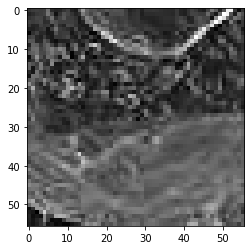

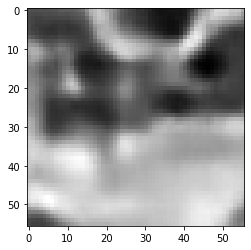

41.02974236011505

 next


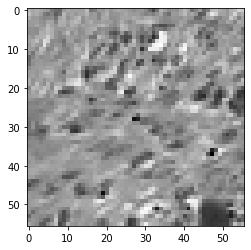

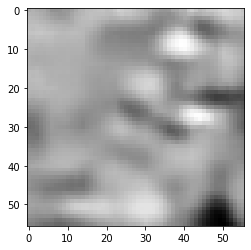

32.66671031713486

 next


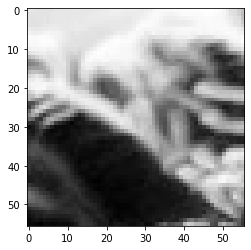

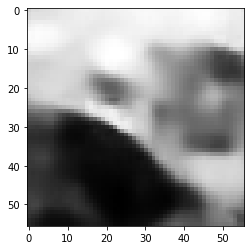

113.61003533005714

 next


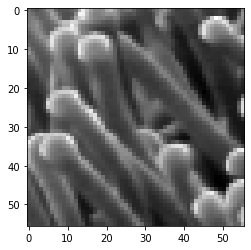

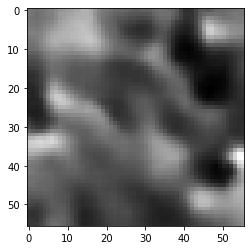

32.545344829559326

 next


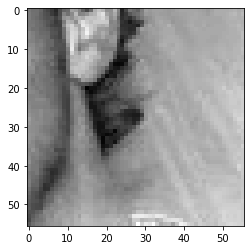

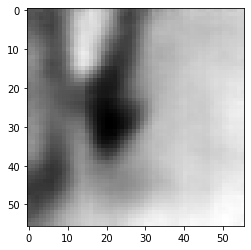

17.928070686757565

 next


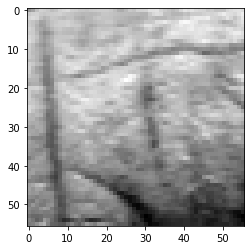

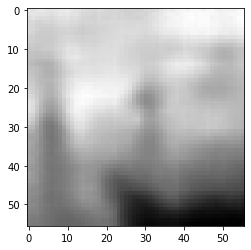

28.53576198220253

 next


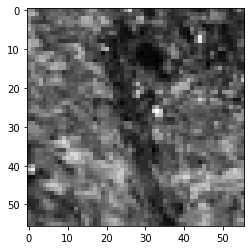

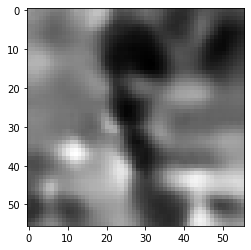

47.64311648905277

 next


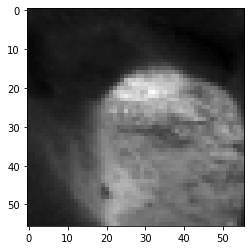

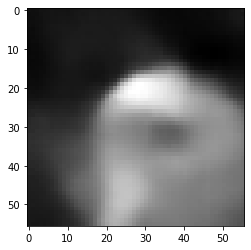

50.46049050986767

 next


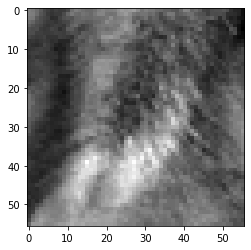

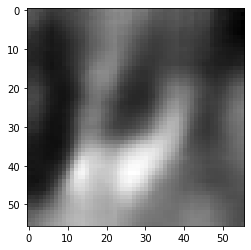

21.7596672847867

 next


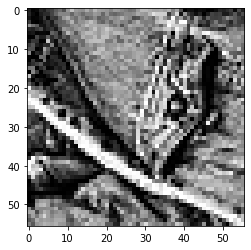

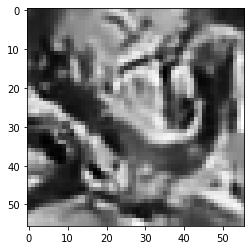

94.0927854180336

 next


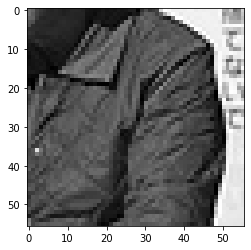

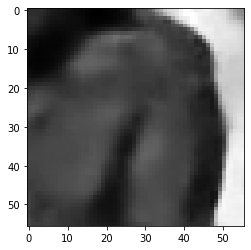

82.46204271912575

 next


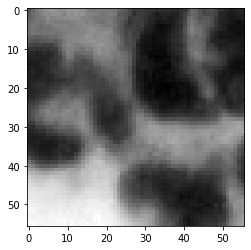

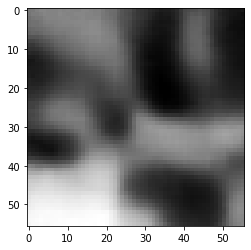

37.367772459983826

 next


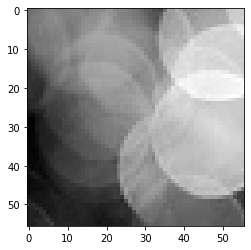

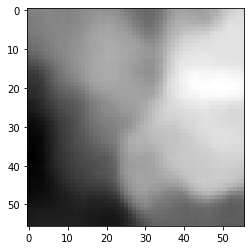

75.96807718276978

 next


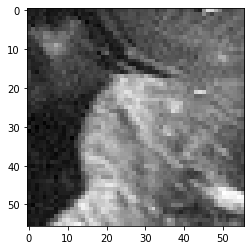

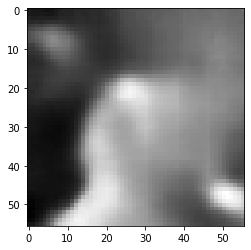

29.482150599360466

 next


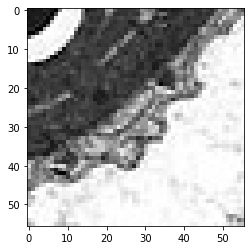

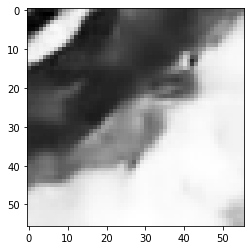

99.12701368331909

 next


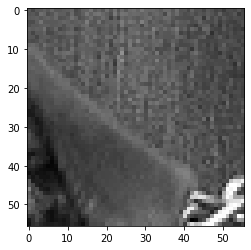

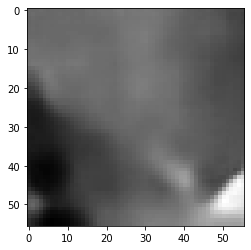

36.17925323545933

 next


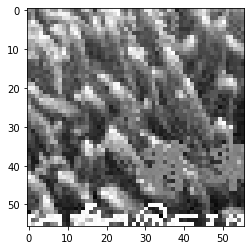

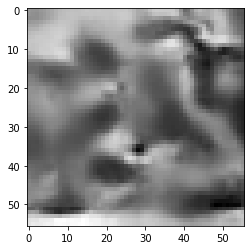

58.283579126000404

 next


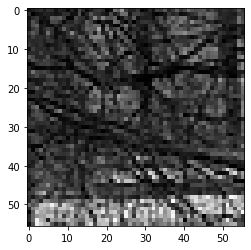

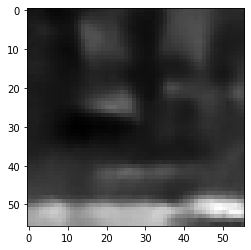

54.83344025909901

 next


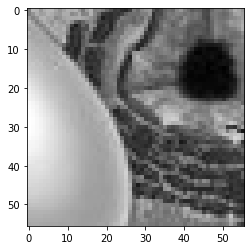

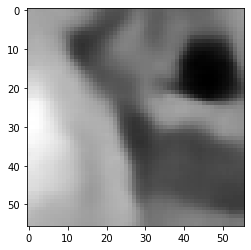

71.65604576468468

 next


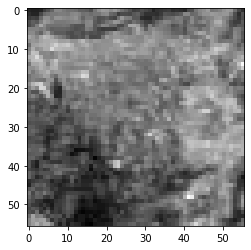

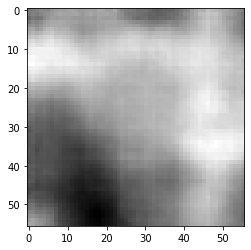

13.596398122608662

 next


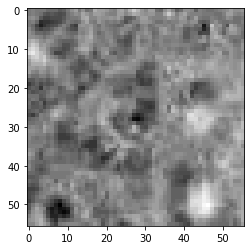

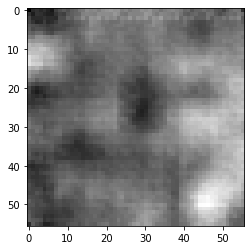

4.766603400930762

 next


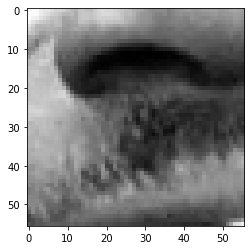

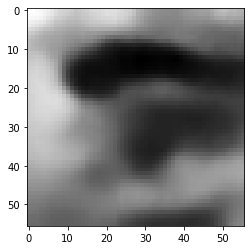

50.406875386834145

 next


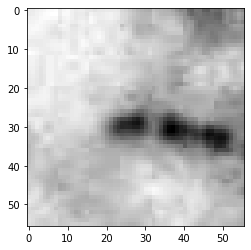

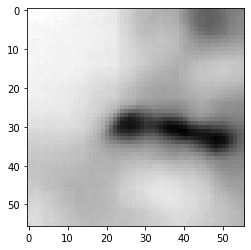

26.16666130721569

 next


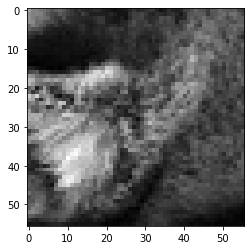

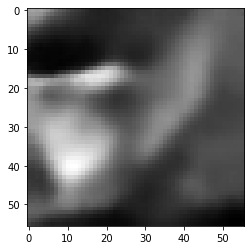

41.68298430740833

 next


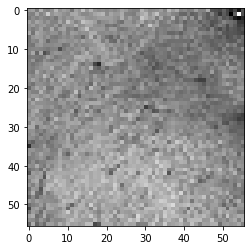

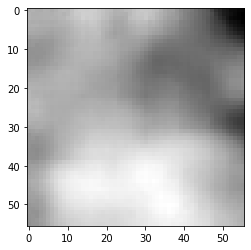

30.333097837865353

 next


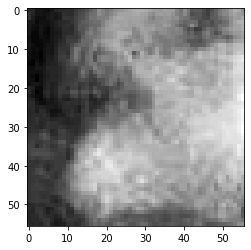

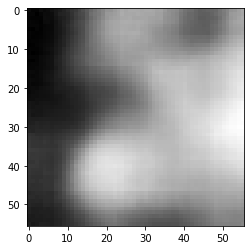

22.074472792446613

 next


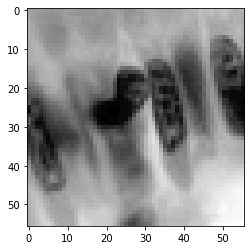

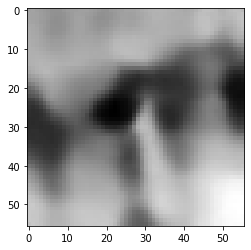

59.34354364871979

 next


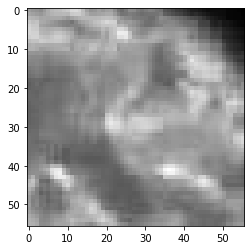

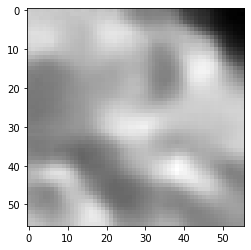

29.430209286510944

 next


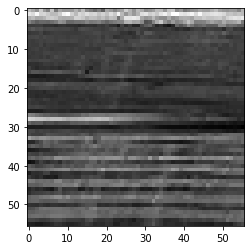

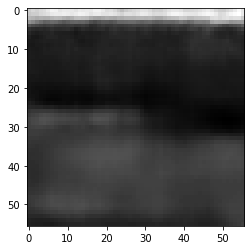

40.268156826496124

 next


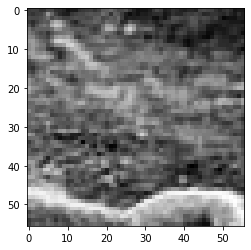

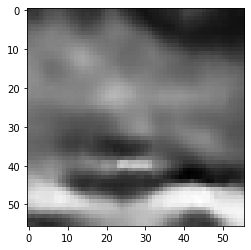

39.862817376852036

 next


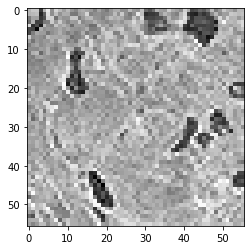

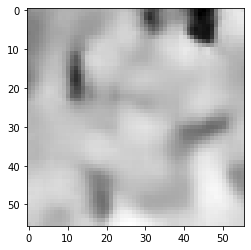

42.15252511203289

 next


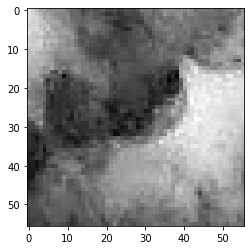

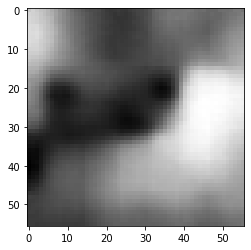

29.733951687812805

 next


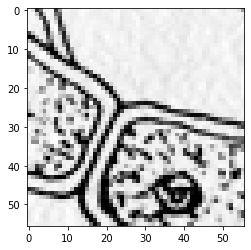

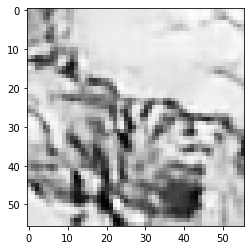

96.6327515244484

 next


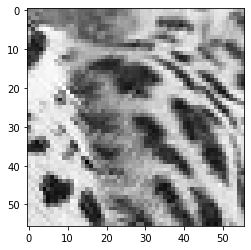

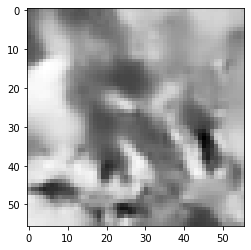

68.97053986787796

 next


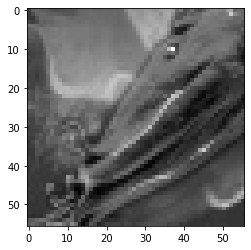

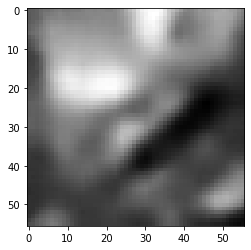

34.44536067545414

 next


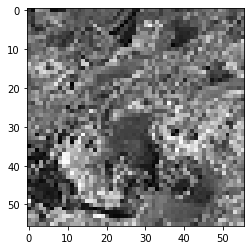

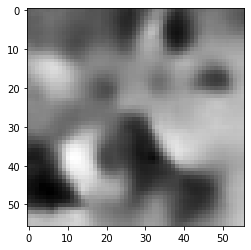

55.07587105035782

 next


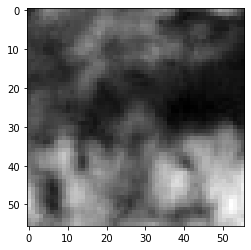

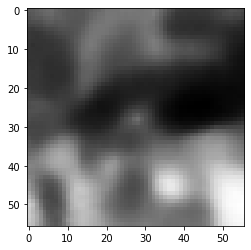

47.69541688263416

 next


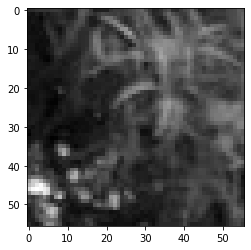

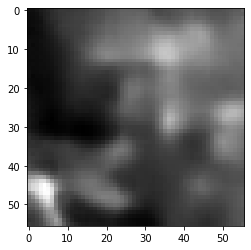

28.896885104477406

 next


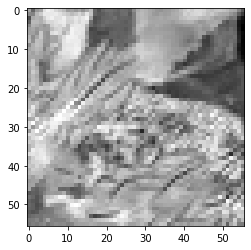

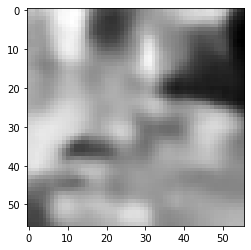

52.10522845387459

 next


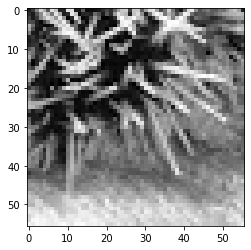

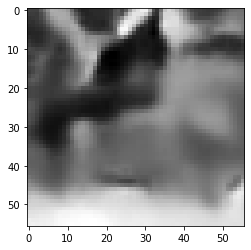

76.63294270634651

 next


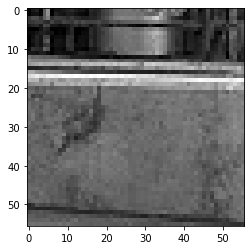

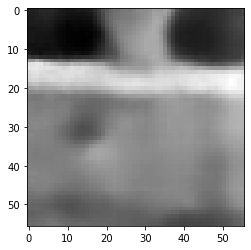

44.42616730928421

 next


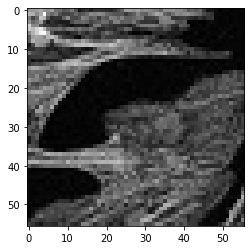

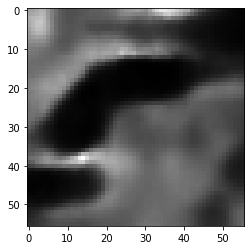

32.23716236650944

 next


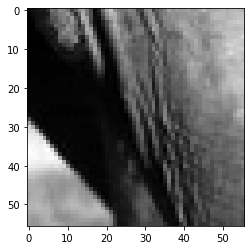

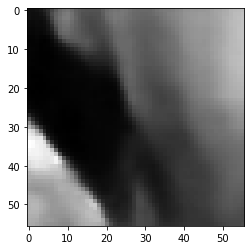

59.32765670120716

 next


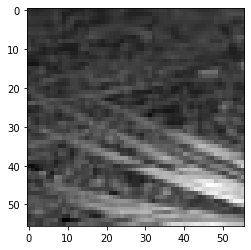

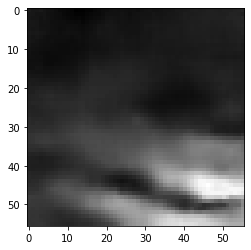

32.64104649424553

 next


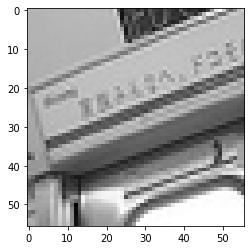

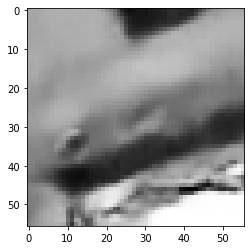

70.95027163624763

 next


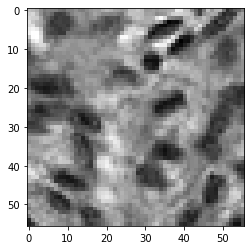

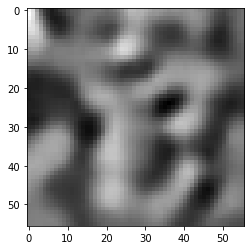

41.65038585662842

 next


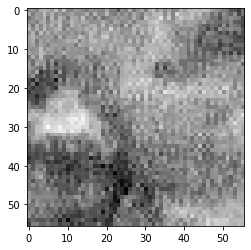

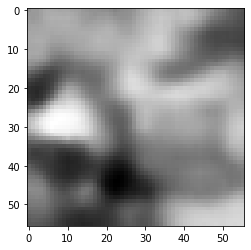

49.33949366211891

 next


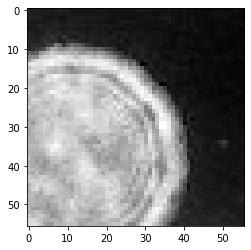

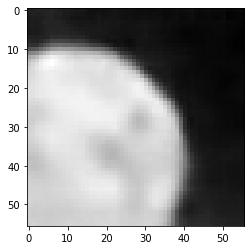

66.16573557257652

 next


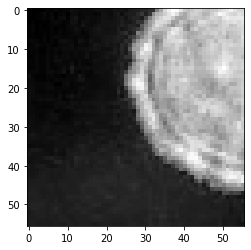

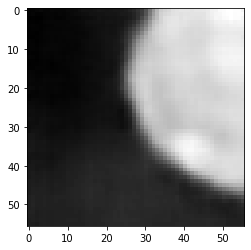

58.430703431367874

 next


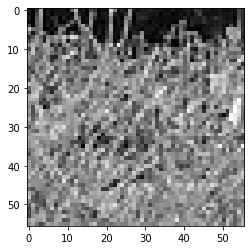

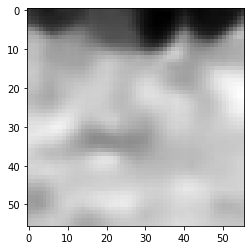

60.541410371661186

 next


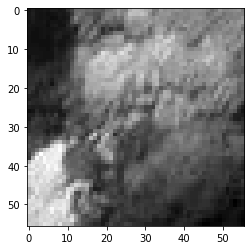

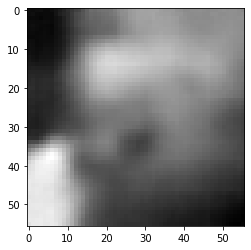

28.079212680459023

 next


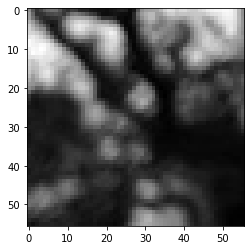

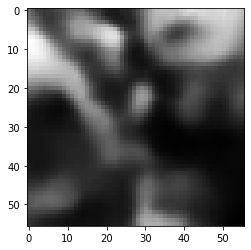

59.941069185733795

 next


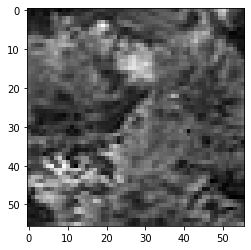

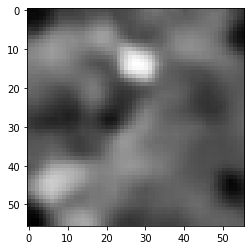

30.4947392642498

 next


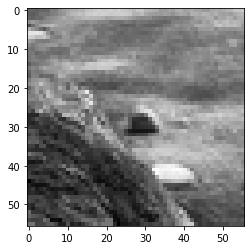

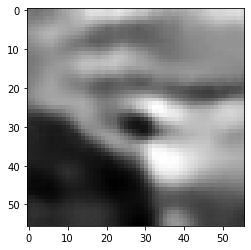

54.698551297187805

 next


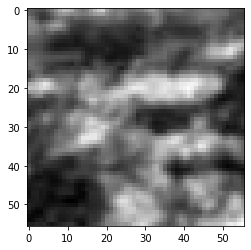

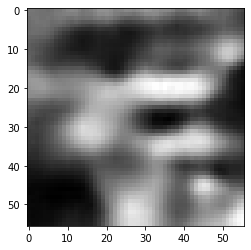

31.234709657728672

 next


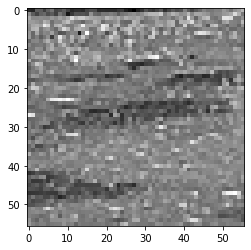

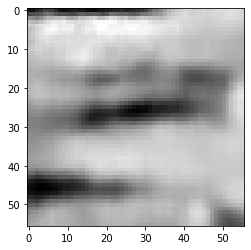

33.6368552595377

 next


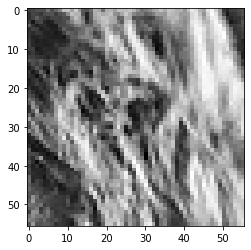

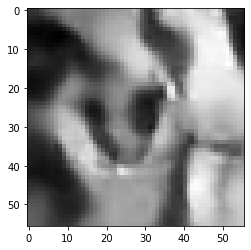

73.93796011805534

 next


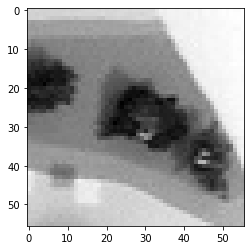

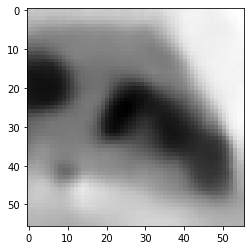

59.52051915228367

 next


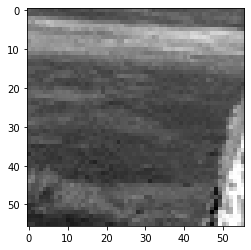

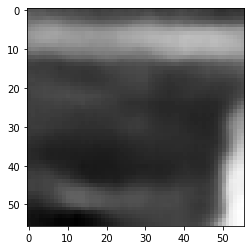

50.86797684431076

 next


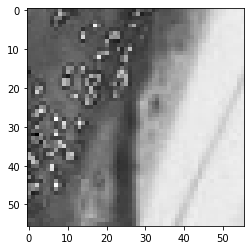

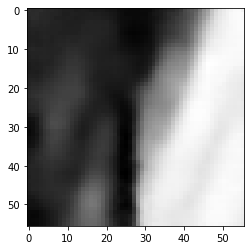

76.18078216910362

 next


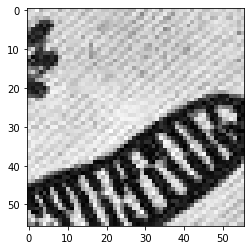

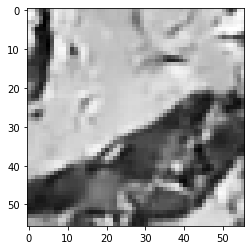

93.14527586102486

 next


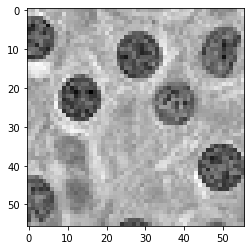

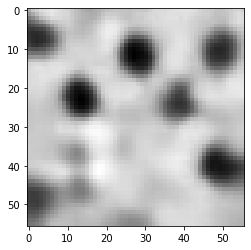

50.24089649319649

 next


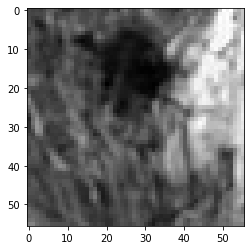

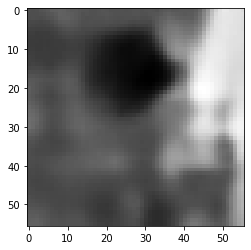

68.46109360456467

 next


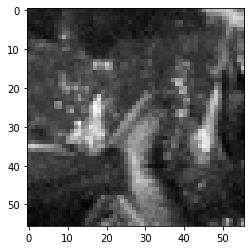

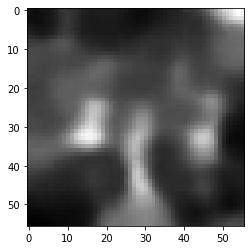

34.254713505506516

 next


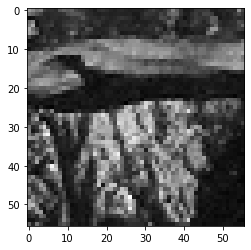

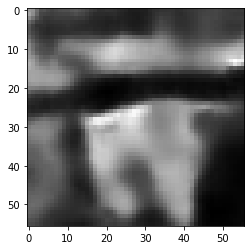

60.313935577869415

 next


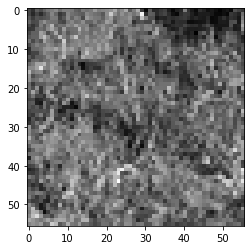

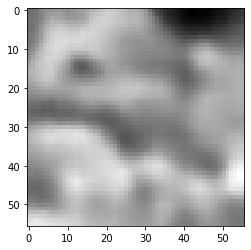

31.990726590156555

 next


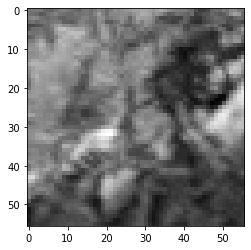

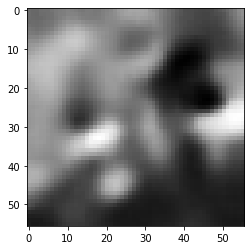

40.17773687839508

 next


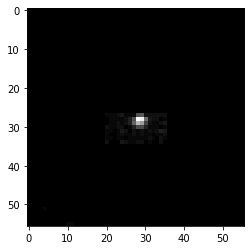

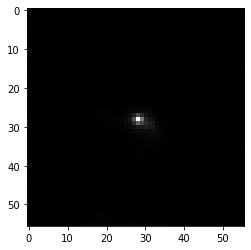

1.315955480094999

 next


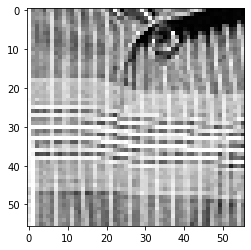

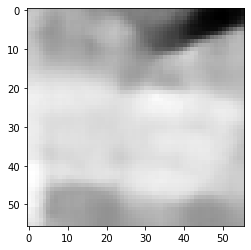

71.46854102611542

 next


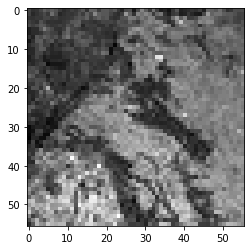

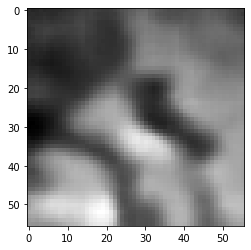

30.50059475004673

 next


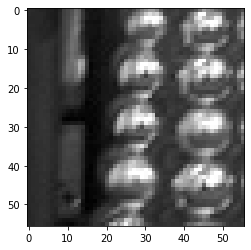

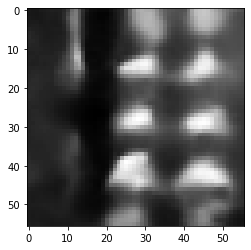

74.51049819588661

 next


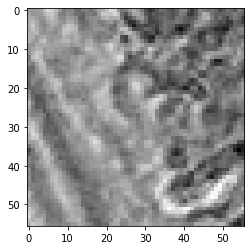

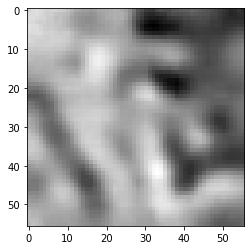

30.555841885507107

 next


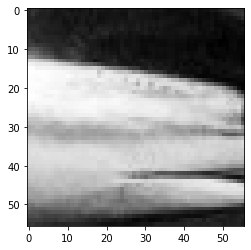

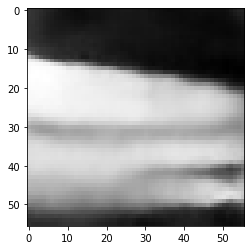

100.5032466351986

 next


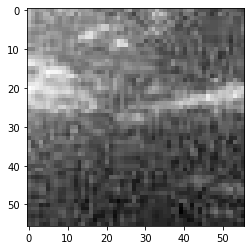

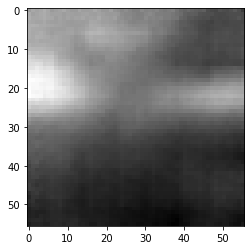

10.842473097145557

 next


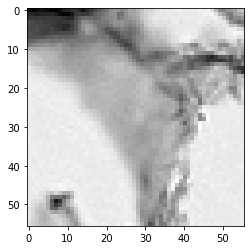

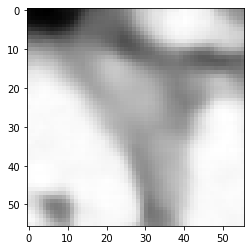

60.54644130170345

 next


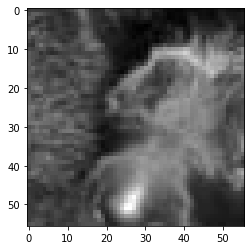

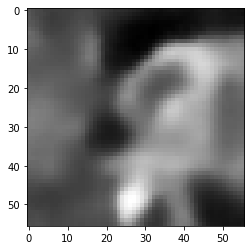

46.09352923929691

 next


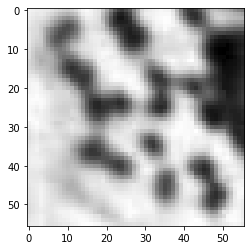

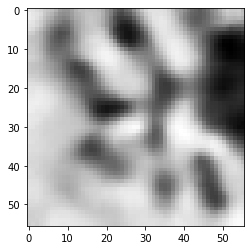

49.820882230997086

 next


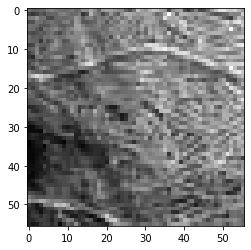

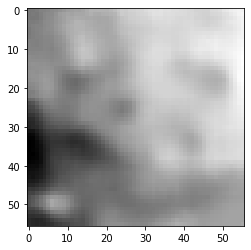

37.79987007379532

 next


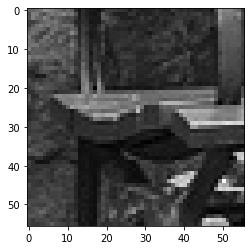

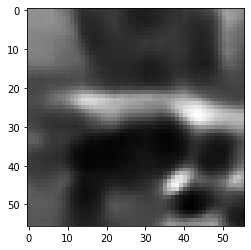

35.711388140916824

 next


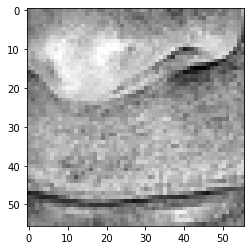

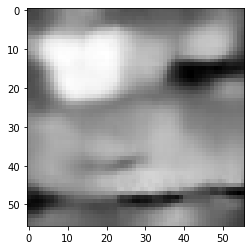

47.3325439542532

 next


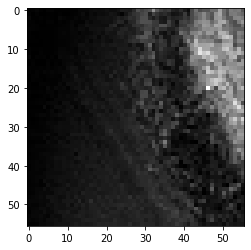

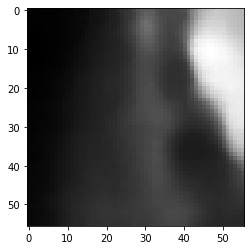

49.11801874637604

 next


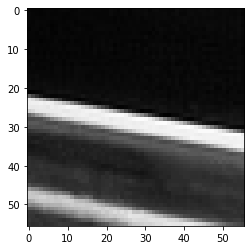

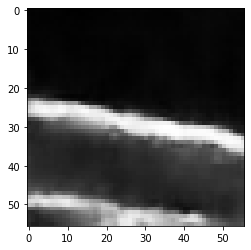

92.82461866736412

 next


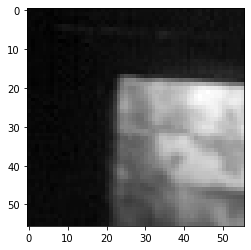

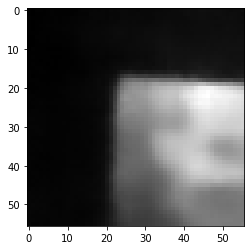

68.02030205726624

 next


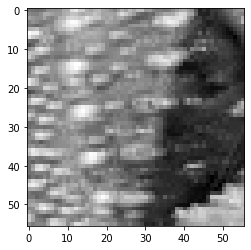

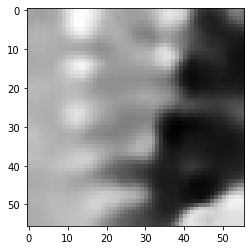

56.06976091861725

 next


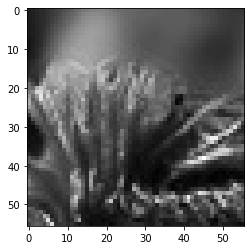

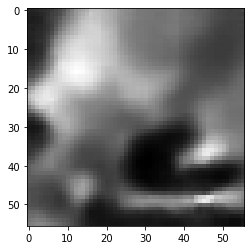

34.537034556269646

 next


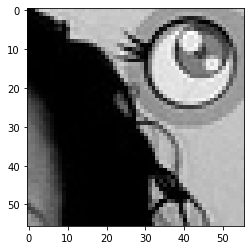

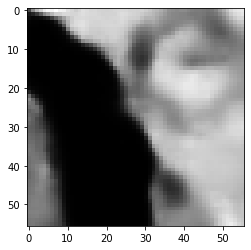

89.90880712866783

 next


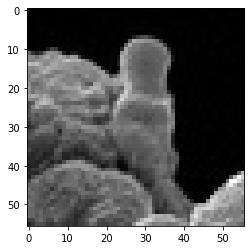

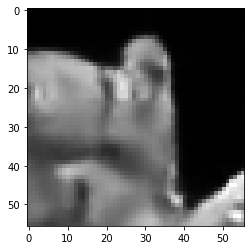

84.88400235772133

 next


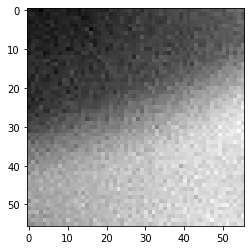

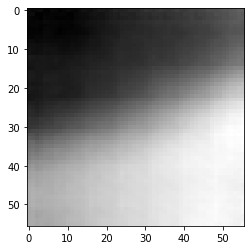

22.403443939983845

 next


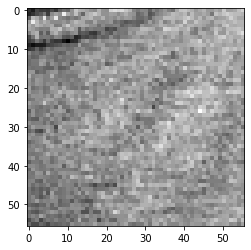

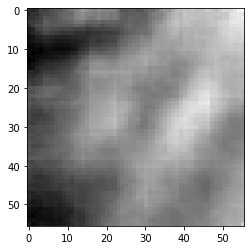

9.77321332320571

 next


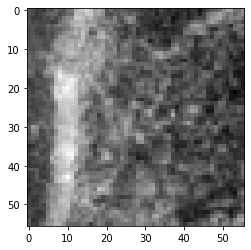

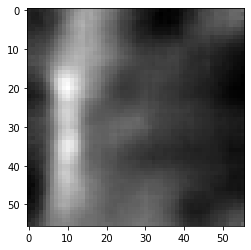

13.4226761944592

 next


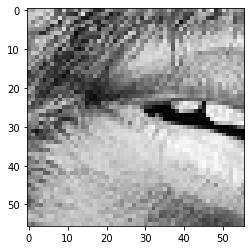

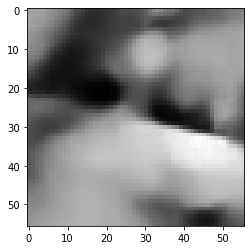

67.19378560781479

 next


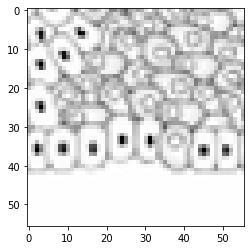

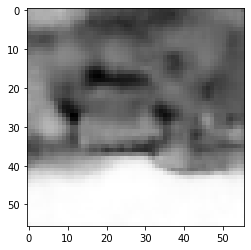

46.691050976514816

 next


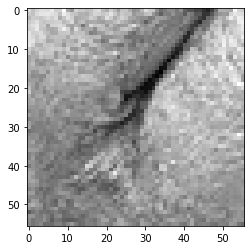

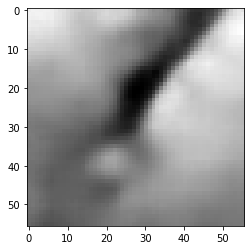

41.57483071088791

 next


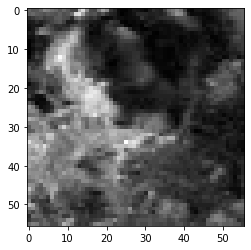

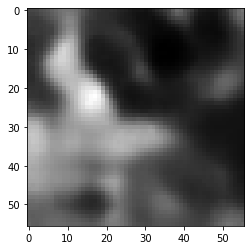

39.552309438586235

 next


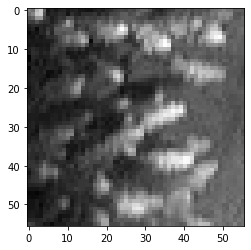

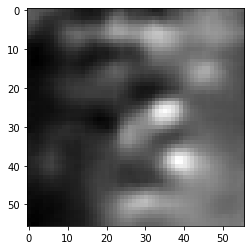

21.64704702794552

 next


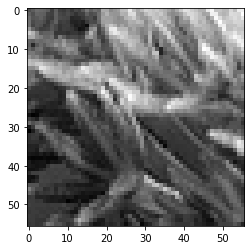

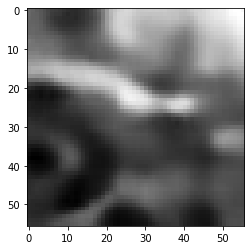

65.7539364695549

 next


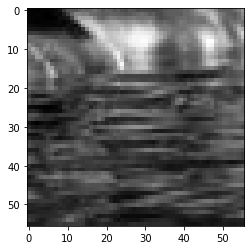

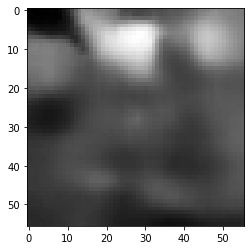

41.843890473246574

 next


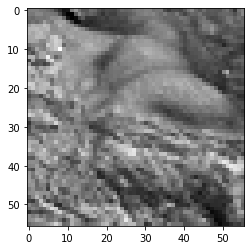

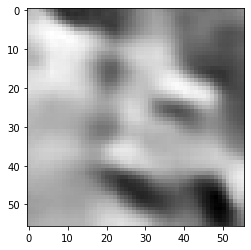

32.47755266726017

 next


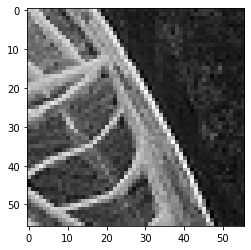

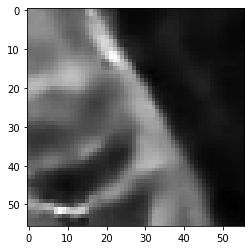

66.25917255878448

 next


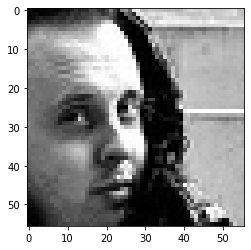

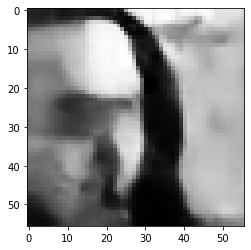

111.95452496409416

 next
0.1945765868993476


In [30]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], patch_size, patch_size, 1)
images = images / 255
predictions = decoder.predict_on_batch(encoder.predict_on_batch(np.array(images)))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape((patch_size, patch_size, 1))
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
#     ground_truth = im_1[5: 53, 5: 53, 0]
#     ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
#     plt.imshow(ground_truth[:, :], cmap='gray')
#     plt.show()
    
    
    pred_1 = predictions[i].reshape((patch_size, patch_size))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(im_1, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [16]:
# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())

# history_callback = vae.fit(x_train, epochs=65*batch_size, batch_size=batch_size)

# model_version = "0.0.0.5"
# vae.save_weights(base_dir + '/vae_' + model_version + '.h5')
